# Aprendizaje de Máquinas (Machine Learning)
## Clase 5: Clasificación (segunda parte)


### 1. Configuración del ambiente

Antes que empezar a trabajar, vamos a preparar el ambiente.
Para ello:
* Montamos Google Drive para guardar allí los archivos que descarguemos. En la consola nos va a aparecer una solicitud para hacer clic en una URL, loggearnos con nuestra cuenta de Google y colocar un código de autorización en una casilla.

In [ ]:
# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs, path
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales

# importamos pandas y seaborn
import seaborn as sn
import pandas as pd

# importo una librería para utilizar valores aleatorios
import random

# importamos pickle para poder ir guardando los distintos modelos
import pickle

# importo matplotlib
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### 2. Acceso a datos y modelos entrenados la clase pasada

Vamos a cargar los datos que ya preparamos la clase pasada, para evitar tener que hacer todo el procesamiento nuevamente. También vamos a cargar los modelos que entrenamos, así no repetimos todo el proceso de model selection.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# cargamos los datos preparados
dataset_filename = path.join(datasets_folder, 'breast_cancer_partitioned.pkl')
with open(dataset_filename, 'rb') as f:
    dataset = pickle.load(f)

# cargamos el modelo básico de logistic regression
model_filename = path.join(datasets_folder, 'breast_cancer_basic_log_reg.pkl')
with open(model_filename, 'rb') as f:
    log_reg_model = pickle.load(f)['model']
print(log_reg_model)

# cargamos el modelo regularizado (comentar el regularizador que no hayan calculado)
regularizer = 'l2'
#regularizer = 'l1'
model_filename = path.join(datasets_folder, 'breast_cancer_{}_reg_log_reg.pkl'.format(regularizer))
if path.exists(model_filename):
  with open(model_filename, 'rb') as f:
      reg_log_reg_model = pickle.load(f)['model']
print(reg_log_reg_model)

# cargamos la svm
model_filename = path.join(datasets_folder, 'breast_cancer_svm.pkl')
with open(model_filename, 'rb') as f:
    svm = pickle.load(f)['model']
print(svm)

# cargamos el random forest
model_filename = path.join(datasets_folder, 'breast_cancer_rf.pkl')
with open(model_filename, 'rb') as f:
    random_forest = pickle.load(f)['model']
print(random_forest)

# cargamos el knn
model_filename = path.join(datasets_folder, 'breast_cancer_knn.pkl')
with open(model_filename, 'rb') as f:
    knn = pickle.load(f)['model']
print(knn)


# construimos una lista con todos los modelos
models_to_evaluate = [log_reg_model, reg_log_reg_model, svm, random_forest, knn]
model_names = ['Basic Log Reg', 'Regularized Log Reg', 'SVM', 'Random Forest', 'kNN']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_

### 3. Algunas métricas (nuevas) de evaluación

Hasta ahora veníamos comparando los algoritmos en función de su accuracy sobre los datos de validación. Sin embargo, existen un montón de otras métricas que nos permiten analizar otras características de los modelos que son igual de interesantes que el número de aciertos.

Vamos a evaluar diferentes métricas usando los resultados que obtenemos en los datos de test. Para eso lo primero que necesitamos hacer es obtener predicciones sobre esos datos, y ya que estamos comparemos sus valores de accuracy.



In [ ]:
from sklearn.metrics import accuracy_score

# inicializamos una lista en la que vamos a ir guardando los resultados
results_in_test_set = []
# inicializamos un arreglo donde guardamos los valores de accuracy
accuracies = np.zeros(len(model_names))

# iteramos por cada uno de los modelos
i=0
for current_model in models_to_evaluate:
  print('Running {} in the test set'.format(model_names[i]))
  # hacemos predicciones sobre los datos de test
  y_hat_test = current_model.predict(dataset['X_test'])
  # las agregamos a la lista de resultados
  results_in_test_set.append(y_hat_test)
  # calculamos el accuracy y lo guardamos en el arreglo
  accuracies[i] = accuracy_score(dataset['y_test'], y_hat_test)
  print('- Accuracy = {:.4f}'.format(accuracies[i]))
  i = i+1


Running Basic Log Reg in the test set
- Accuracy = 0.9532
Running Regularized Log Reg in the test set
- Accuracy = 0.9766
Running SVM in the test set
- Accuracy = 0.9766
Running Random Forest in the test set
- Accuracy = 0.9415
Running kNN in the test set
- Accuracy = 0.9591


En principio vemos que algo de lo que vimos en los datos de validación se mantiene sobre los datos de test. Los modelos no lineales son los que menos bien funcionan, seguidos por el modelo de regresión logística sin regularización. Los modelos regularizados (ya sea el de regresión logística o la SVM) obtuvieron los mismos valores de accuracy. Ahora bien, ¿funcionan exactamente igual?

#### 3.1. Sensitividad y especificidad: entendiendo positivos y negativos

En general, cuando tenemos problemas de clasificación binaria no nos interesa saber únicamente la proporción de muestras que el algoritmo acertó, si no que también queremos saber qué tan bueno fue para detectar una clase o la otra, por separado. Esta información nos la dan dos métricas: [la sensitividad (sensitivity) y la especificidad (specificity)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity).

La sensitividad se define como: $\text{Se} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{TP}}{P}$, donde TP es el número de true positives (cantidad de muestras positivas correctamente detectadas) y FN es el número de false negatives (cantidad de muestras positivas detectadas erroneamente como negativas). El denominador fíjense que podemos reemplazarlo también por $P$, que es el número total de muestras positivas que tenemos en nuestros datos.

La especificidad se define como: $\text{Sp} = \frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{\text{TN}}{N}$, donde TN es el número de true negatives (cantidad de muestras negativas detectadas) y FP es el número de false positives (cantidad de muestras negativas detectadas erroneamente como positivas). El denominador fíjense que podemos reemplazarlo también por $P$, que es el número total de muestras negativas que tenemos en nuestros datos.

La sensitividad nos dice qué tan bien nuestro algoritmo detecta la clase positiva, y la especificidad qué tan bien detecta nuestro algoritmo la clase negativa. La especificidad podría verse incluso como "la sensitividad para la clase negativa", si comparan las ecuaciones. Ambas métricas están acotadas entre 0 y 1. Cuando son 0, es porque la cantidad de TP o TN es 0 (para sensitividad o especificidad, respectivamente). Cuando la sensitividad o especificidad dan 1, es porque la cantidad de TP o TN coincide con el número total de muestras positivas o negativas, respectivamente. 

En general las analizamos a las dos a la vez, porque siempre es posible obtener un método con sensitividad (especificidad) = 100% prediciendo que cualquier entrada es positiva (negativa). Si estudiamos la relación entre ambas podemos de alguna manera "descomponer" el valor de accuracy y entender un poco más en detalle qué hace nuestro algoritmo.

Evaluemos los valores de sensitividad y especificad de los algoritmos con los que estábamos trabajando, sobre los datos de test:

Our classifiers take samples and classify them in:
['malignant', 'benign']
Basic Log Reg:
- Sensitivity = 0.9533
- Specificity = 0.9531
Regularized Log Reg:
- Sensitivity = 0.9813
- Specificity = 0.9688
SVM:
- Sensitivity = 0.9907
- Specificity = 0.9531
Random Forest:
- Sensitivity = 0.9533
- Specificity = 0.9219
kNN:
- Sensitivity = 0.9907
- Specificity = 0.9062


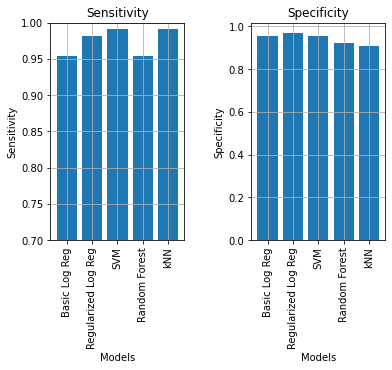

In [ ]:
def sensitivity(y_true, y_pred):
  '''
  Sensitividad = TP / P
  '''
  # contamos las muestras positivas
  P = np.sum(y_true)
  # contamos las muestras positivas que coinciden con las positivas de y_pred
  TP = np.sum(np.logical_and(y_true, y_pred))
  return TP / P


def specificity(y_true, y_pred):
  '''
  Especificidad = TN / N
  '''
  return sensitivity(np.logical_not(y_true), np.logical_not(y_pred))


# recordemos qué representa cada clase
print('Our classifiers take samples and classify them in:')
print(dataset['target_names'])
print('=====================')

# inicializamos arreglos en cero para los valores de sensitividad/especificidad
sensitivities = np.zeros(len(model_names))
specificities = np.zeros(len(model_names))
# iteramos por cada modelo y vamos calculando sus valores de sensitividad/especificidad
for i in range(len(model_names)):
  print('{}:'.format(model_names[i]))
  sensitivities[i] = sensitivity(dataset['y_test'], results_in_test_set[i])
  specificities[i] = specificity(dataset['y_test'], results_in_test_set[i])
  print('- Sensitivity = {:.4f}'.format(sensitivities[i]))
  print('- Specificity = {:.4f}'.format(specificities[i]))
  print('=====================')


# inicializamos un gráfico para cada métrica
fig, axes = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
# graficamos las sensitivities
axes[0].bar(np.arange(sensitivities.size), sensitivities)
axes[0].set_title('Sensitivity')
axes[0].set_ylim(0.7, 1.0)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Sensitivity')
axes[0].set_xticks(np.arange(sensitivities.size))
axes[0].set_xticklabels(model_names, rotation=90)
axes[0].grid(True)
# y las specificities
axes[1].bar(np.arange(specificities.size), specificities)
axes[1].set_title('Specificity')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Specificity')
axes[1].set_xticks(np.arange(specificities.size))
axes[1].set_xticklabels(model_names, rotation=90)
axes[1].grid(True)

plt.show()

Donde antes teníamos métodos con un accuracy equivalente (la SVM y el método regularizado de logistic regresion), ahora vemos que hay diferencias en sus valores de sensitividad y especificidad. Comparémoslos individualmente:

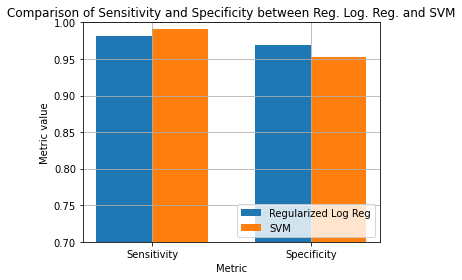

In [ ]:
labels = ['Sensitivity', 'Specificity']
# buscamos la posición de los dos modelos que queremos comparar
idx_log_reg = model_names.index('Regularized Log Reg')
idx_svm = model_names.index('SVM')
# nos quedamos con sus valores de sensitividad y especificidad
reg_log_reg_metrics = [sensitivities[idx_log_reg], specificities[idx_log_reg]]
svm_metrics = [sensitivities[idx_svm], specificities[idx_svm]]
# los ploteamos juntos en un mismo gráfico
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x-(width/2), reg_log_reg_metrics, width, label='Regularized Log Reg')
rects2 = ax.bar(x+(width/2), svm_metrics, width, label='SVM')
ax.set_ylim(0.7, 1.0)
ax.legend(['Regularized Log Reg', 'SVM'], loc='lower right')
ax.set_xticks(x)
ax.set_title('Comparison of Sensitivity and Specificity between Reg. Log. Reg. and SVM')
ax.set_xticklabels(labels)
ax.set_ylabel('Metric value')
ax.set_xlabel('Metric')
ax.grid(True)
fig.tight_layout()
plt.show()

Vemos que el algoritmo de regresión logística tiene una menos sensitividad comparado con la SVM, pero que a la vez tiene una mayor especificidad. Dependiendo de la aplicación, deberíamos elegir alguno de los dos para aplicar, ya que ambos tienen la misma accuracy.

En este caso, estamos trabajando en un problema médico que consiste en detectar si un determinado quiste de mama es benigno, en función de sus características. Un modelo con mucha sensitividad va a ser capaz de detectar muy bien los benignos. Sin embargo, si no aseguramos una alta especificidad, puede confundir quistes malignos con benignos, y eso puede ser (SUPER) problemático: tumores que deberían tratarse por ser malignos serían ignorados por creer que en realidad no lo eran! ¿Cuál de los modelos disponibles les parece entonces el mejor?

#### 3.2. Curvas ROC: eligiendo el umbral

Algunos clasificadores pueden proveernos un score que podemos emplear para, por ejemplo, interpretar su salida de manera "probabilística". Así, en lugar de obtener una respuesta binaria, obtenemos un número que podemos pensar como una probabilidad de pertenecer a una u otra clase, y que podríamos umbralar en algún valor específico.

Vamos a calcular las predicciones probabilísticas de cada modelo, usando el método ```predict_proba()```. Tengan en cuenta que estas predicciones se calculan de distinta forma, dependiendo del algoritmo:
* Logistic Regression: es la salida de la función sigmoidea que aplicamos a los scores del clasificador lineal.
* Random Forest: es la cantidad de árboles que votaron por la clase dividido el total de árboles.
* kNN: es la cantidad de vecinos que votaron por la clase dividido el total de vecinos.

En el caso particular de la SVM, notarán que utilizamos otro método, llamado ```decision_function()```. Esto es porque la SVM no nos da per se un valor de probabilidad, si no la distancia del punto respecto al hiperplano aprendido. Este valor puede usarse como un score, aunque [no está calibrado](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/#:~:text=Calibration%20of%20prediction%20probabilities%20is,Platt%20Scaling%20and%20Isotonic%20Regression). La calibración de scores es un mundo en sí mismo que lamentablemente no podemos cubrir en este curso, pero tomemos por ahora esos valores.

In [ ]:
# inicializamos una lista en la que vamos a ir guardando los resultados
score_based_results_in_test_set = []

# iteramos por cada uno de los modelos
i=0
for current_model in models_to_evaluate:
  print('Running {} in the test set'.format(model_names[i]))
  # hacemos predicciones sobre los datos de test
  if model_names[i]!='SVM':
    # predecimos las probabilidades
    y_hat_test = current_model.predict_proba(dataset['X_test'])
    # tenemos que quedarnos con las de la clase positiva
    y_hat_test = y_hat_test[:,1]
  else:
    # predecimos la distancia al hiperplano
    y_hat_test = current_model.decision_function(dataset['X_test'])
  print(' -- {} ...'.format(y_hat_test[0:10]))
  # las agregamos a la lista de resultados
  score_based_results_in_test_set.append(y_hat_test)
  i = i+1

Running Basic Log Reg in the test set
 -- [1. 1. 1. 0. 0. 0. 1. 0. 1. 1.] ...
Running Regularized Log Reg in the test set
 -- [0.999 1.    1.    0.003 0.    0.211 0.971 0.013 0.892 0.994] ...
Running SVM in the test set
 -- [ 1.736  2.202  1.88  -1.104 -1.927 -0.016  1.088 -0.664  0.728  1.291] ...
Running Random Forest in the test set
 -- [1.   0.88 1.   0.12 0.   0.32 0.96 0.16 1.   0.96] ...
Running kNN in the test set
 -- [1.    1.    1.    0.    0.    0.667 1.    0.    0.667 1.   ] ...


Existe una herramienta para evaluar qué tan buenos son esos scores: [la curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). En estas curvas se representan los diferentes valores de sensitividad y especificidad que se obtienen al umbralar los scores utilizando diferentes valores. En particular, cada umbral tiene asociado un valor de TPR (true positive ratio, equivalente a la sensitivity) y otro de FPR (false positive ratio, equivalente a 1 - specificity), ya que al umbralar podemos contar la cantidad de TP y FP. Luego, uniendo los puntos podemos obtener una curva que nos represente todos esos posibles valores juntos.

¿Cómo se interpreta esta curva?
* La **curva ROC es óptima cuando tiene un vértice en el punto TPR=1 y FPR=0** (ubicado en el vértice superior izquierdo). Esto significa que para algún cierto umbral es capaz de obtener 100% de true positives sin tener ni un solo falso positivo. 
* **La peor de las curvas ocurre cuando cada vez que crece el TPR crece también el FPR en igual proporción.** Esa curva suele verse como una recta en diagonal que une el punto (0.0, 0.0) (el vértice inferior izquierdo) con el (1.0, 1.0) (el vértice superior derecho). El modelo se dice entonces que es completamente aleatorio: arriesga cosas cuando predice, y esas cosas tienen igual probabilidad de estar bien o mal.
* **La curva ROC que esté por debajo de la curva asociada a modelos aleatorios se dice que corresponde a un modelo inverso.** Esto es: cada vez que predigo, tengo más chances de predecir un falso positivo que un true positive. ¿Cómo podría corregirlo? Simplemente invirtiendo el valor de probabilidad de salida. Así, lo que antes era un falso positivo ahora será un true positive, y viceversa.
* El **area debajo de la curva (Area Under the Curve, AUC)** es un indicador numérico que nos resume qué tan buena es la curva. Cuanto más cercano a 1 es, mejor es la curva. Cuanto más cercano a 0.5 es, entonces más aleatorio es el modelo. Si el valor de AUC es menor a 0.5, entonces el modelo está prediciendo las cosas al revés! En esos casos, conviene revisar si no estamos haciendo algo mal en el etiquetado o el preparado de los datos.

Vamos a calcular las curvas ROC para nuestros distintos modelos, y calcular sus respectivos valores de AUC.

Basic Log Reg - AUC = 0.9817
Regularized Log Reg - AUC = 0.9915
SVM - AUC = 0.9888
Random Forest - AUC = 0.9845
kNN - AUC = 0.9812


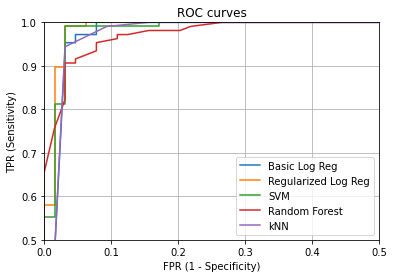

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# variable para determinar si queremos hacer zoom o no
#zoom = False
zoom = True

# inicializamos una matriz para los valores de AUC
auc_values = np.zeros(len(model_names))

# recorremos cada uno de los modelos
for i in range(len(model_names)):
  # generamos la curva roc
  fpr, tpr, thresholds = roc_curve(dataset['y_test'], score_based_results_in_test_set[i])
  auc_values[i] = roc_auc_score(dataset['y_test'], score_based_results_in_test_set[i])
  # la mostramos
  plt.plot(fpr, tpr)
  print('{} - AUC = {:.4f}'.format(model_names[i], auc_values[i]))

# si queremos aplicar un zoom
if zoom:
  plt.xlim(0.0, 0.5)
  plt.ylim(0.5, 1.0)  
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('ROC curves')
plt.grid(True)
plt.legend(model_names, loc='lower right')
plt.show()


Podemos ver que si consideramos scores, el modelo de regresión logística regularizada es el que nos permite obtener una mejor curva ROC, ya que arroja el mejor valor de area bajo la curva.

### 4. Problemas de clase sesgada

Hasta ahora vinimos trabajando con datos que tienen una particularidad: tienen una proporción igual de muestras pertenecientes a cada clase. Esto rara vez ocurre en la vida real. Los datos que solemos recibir siempre tienen un montón de ruido, no solamente en sus características o etiquetas si no también en la forma en la que fueron muestreados. En consecuencia, puede ocurrir que tengamos algunas muestras que sean desproporcionalmente más comunes que otras. En otro casos, el problema en sí mismo es un problema de naturaleza desbalanceada: detectar estrellas en una foto nocturna, por ejemplo, implica un problema en el que muy pocos píxeles pertenecen a la clase de interés (estrella), mientras que todos los demás pertenecen a la otra clase (no estrella).

Los problemas de este tipo suelen conocerse como **de clase sesgada**. Los algoritmos que venimos trabajando hasta acá suelen requerir que establezcamos alguna estrategia correctiva para ayudarlos a entender los datos de mejor manera, así como tenemos que cambiar las métricas que utilizamos para evaluarlos.

En las próximas secciones vamos a tomar un ejemplo, viendo cómo las métricas que utilizamos hasta ahora se rompen y cómo tenemos que adaptar nuestars soluciones para trabajar mejor.

#### 4.1. Preparamos datos para un nuevo problema

Vamos a descargar y preparar los datos de [un dataset de Kaggle creado para detectar fraude en el uso de tarjetas de crédito](https://www.kaggle.com/mlg-ulb/creditcardfraud). El conjunto incluye una serie de features V1, V2, ... V28, cada una de las cuales es el resultado de haber hecho PCA sobre otras features que no podían colocarse en su versión original (por cuestiones de confidencialidad). Además, se incluye el tiempo desde la primera transacción en el dataset y la cantidad de dinero de la transacción como features adicionales. El problema consiste en detectar si la operación fue fraude (1) o no (0).

Vamos a descargar ese archivo y prepararlo como veníamos haciendo hasta ahora.

In [ ]:
# descargamos los datos usando Pandas
df = pd.read_csv('https://query.data.world/s/rr62wuvzi3yg2vizv3ro6wpd253n44')

# inicializamos un diccionario para guardar el dataset
dataset = dict()
# nos quedamos con los tags de las columnas
dataset['feature_labels'] = []
for col in df.columns: 
    dataset['feature_labels'].append(col)
dataset['feature_labels'] = dataset['feature_labels'][:-1]
# asignamos las etiquetas de las variables objetivo
dataset['target_names'] = ['not-fraud', 'fraud']
# pasamos a numpy y nos quedamos con las features y las etiquetas
data = df.to_numpy()
X = data[:,:-1]
y = data[:,-1]

# imprimimos las estadísticas
print('======================')
print('ORIGINAL CREDIT CARD FRAUD DATASET')
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))
print('Feature names: {}'.format(dataset['feature_labels']))
print('Classes: {}'.format(np.unique(y)))
print('Target names: {}'.format(dataset['target_names']))
print('% samples per class')
for i in range(len(np.unique(y))):
  print('--> {} : {:2.2f}%'.format(i, np.sum(y==i)/y.size*100))
print('======================')


ORIGINAL CREDIT CARD FRAUD DATASET
Num samples: 284807
Num features: 30
Feature names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Classes: [0. 1.]
Target names: ['not-fraud', 'fraud']
% samples per class
--> 0 : 99.83%
--> 1 : 0.17%


Podemos ver que en la enorme mayoría de los casos las muestras corresponden a datos no fraudulentos (un 99.83% vs. 0.17%). Este problema es tremendamente desbalanceado, y nos va a servir de ejemplo para lo que queremos ir viendo.

Generemos las particiones de training, validation y test usando muestreo estratificado.

In [ ]:
from sklearn.model_selection import train_test_split

# generamos las particiones de entrenamiento/val y test
X_train_val, dataset['X_test'], y_train_val, dataset['y_test'] = train_test_split(X, y, test_size=0.30, random_state=10, stratify=y)
# y hacemos lo mismo para generar los datos de entrenamiento/validación
dataset['X_train'], dataset['X_val'], dataset['y_train'], dataset['y_val'] = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=11, stratify=y_train_val)

# obtenemos la media y la std de los datos de entrenamiento
dataset['mu'] = np.mean(dataset['X_train'], axis=0)
dataset['std'] = np.std(dataset['X_train'], axis=0)
# estandarizamos los datos
dataset['X_train'] = (dataset['X_train'] - dataset['mu']) / dataset['std']
dataset['X_val'] = (dataset['X_val'] - dataset['mu']) / dataset['std']
dataset['X_test'] = (dataset['X_test'] - dataset['mu']) / dataset['std']

# imprimimos por pantalla los tamaños finales
print('PARTITIONED CREDIT CARD FRAUD DATASET')
print('X_train: {}'.format(dataset['X_train'].shape))
print('y_train: {}'.format(dataset['y_train'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_train']==0)/dataset['y_train'].size*100, np.sum(dataset['y_train']==1)/dataset['y_train'].size*100))
print('----------------------')
print('X_val: {}'.format(dataset['X_val'].shape))
print('y_val: {}'.format(dataset['y_val'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_val']==0)/dataset['y_val'].size*100, np.sum(dataset['y_val']==1)/dataset['y_val'].size*100))
print('----------------------')
print('X_test: {}'.format(dataset['X_test'].shape))
print('y_test: {}'.format(dataset['y_test'].shape))
print('% samples per class: 0 : {:2.2f}%    1 : {:2.2f}%'.format(np.sum(dataset['y_test']==0)/dataset['y_test'].size*100, np.sum(dataset['y_test']==1)/dataset['y_test'].size*100))
print('----------------------')
print('Total: {} samples'.format(dataset['X_train'].shape[0] + dataset['X_val'].shape[0] + dataset['X_test'].shape[0]))
print('======================')

# salvamos los datos para usarlos más adelante
import pickle
dataset_filename = path.join(datasets_folder, 'credit_card_fraud.pkl')
print('\nSaving {}'.format(dataset_filename))
with open(dataset_filename, 'wb') as f:
    pickle.dump(dataset, f)


PARTITIONED CREDIT CARD FRAUD DATASET
X_train: (179427, 30)
y_train: (179427,)
% samples per class: 0 : 99.83%    1 : 0.17%
----------------------
X_val: (19937, 30)
y_val: (19937,)
% samples per class: 0 : 99.83%    1 : 0.17%
----------------------
X_test: (85443, 30)
y_test: (85443,)
% samples per class: 0 : 99.83%    1 : 0.17%
----------------------
Total: 284807 samples

Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/credit_card_fraud.pkl


#### 4.2. Métricas de evaluación

Estamos muy cancherxs entrenando algoritmos de clasificación a esta altura, así que podríamos intentar por ejemplo probar un regresor logístico sobre estos datos, y medir el nivel de accuracy que obtenemos.

l2 Log Reg with C=1e-05 --> Accuracy=0.9983 - Positive samples=0.0
l2 Log Reg with C=0.0001 --> Accuracy=0.9985 - Positive samples=8.0
l2 Log Reg with C=0.001 --> Accuracy=0.9989 - Positive samples=19.0
l2 Log Reg with C=0.01 --> Accuracy=0.9990 - Positive samples=21.0
l2 Log Reg with C=0.1 --> Accuracy=0.9990 - Positive samples=21.0
l2 Log Reg with C=1 --> Accuracy=0.9990 - Positive samples=21.0
l2 Log Reg with C=10 --> Accuracy=0.9991 - Positive samples=22.0
l2 Log Reg with C=100 --> Accuracy=0.9991 - Positive samples=22.0
l2 Log Reg with C=1000 --> Accuracy=0.9991 - Positive samples=22.0


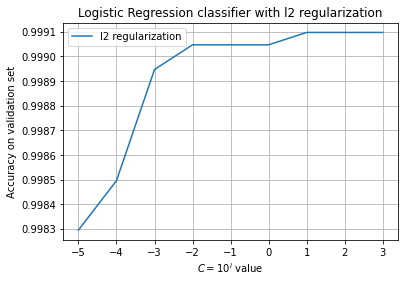

Logistic regression classifier with l2 regularization
-----------------------
Best C: 10
Accuracy on validation set: 0.9991
-----------------------


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# valores de C que vamos a probar
C_values = [-5, -4, -3, -2, -1, 0, 1, 2, 3]

# elegimos el regularizador (comentar la linea que no queremos)
regularizer = 'l2'
#regularizer = 'l1'
# automaticamente elegimos el solver más conveniente
if regularizer == 'l2':
  best_solver = 'lbfgs'
elif regularizer == 'l1': 
  best_solver = 'liblinear'
else:
  raise ValueError('Unrecognized {} regularizer. This example only supports {}'.format(regularizer, ['l1', 'l2']))
long_name = '{} regularized logistic regression'.format(regularizer)

# inicializamos un vector donde guardaremos los valores de accuracy
reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
reg_log_reg_models = []

# probamos cada valor de C
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000)
  reg_log_reg_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su accuracy comparando estas etiquetas con el ground truth
  reg_log_reg_accuracy_val[i] = accuracy_score(dataset['y_val'], y_hat_val)
  print('{} Log Reg with C={} --> Accuracy={:.4f} - Positive samples={}'.format(regularizer, 10**(C_values[i]), reg_log_reg_accuracy_val[i], np.sum(y_hat_val)))

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(reg_log_reg_accuracy_val)
# lo reservamos
regularized_logistic_regression_model = reg_log_reg_models[C_idx]

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
plt.plot(C_values, reg_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('Accuracy on validation set')
plt.title('Logistic Regression classifier with {} regularization'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer)])
plt.show(True)

# imprimimos los resultados por pantalla
print('Logistic regression classifier with {} regularization'.format(regularizer))
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Accuracy on validation set: {:.4f}'.format(reg_log_reg_accuracy_val[C_idx]))
print('-----------------------')

Viendo estos resultados podríamos tentarnos a pensar que el modelo que acabamos de entrenar es casi perfecto. Pista: no.

Para ver dónde le erra, vamos a usar [matrices de confusión](https://en.wikipedia.org/wiki/Confusion_matrix). En el siguiente ejemplo vamos a imprimir la matriz de confusión para este modelo particular que recién entrenamos, y veremos cómo clasificamos las muestras de validación.

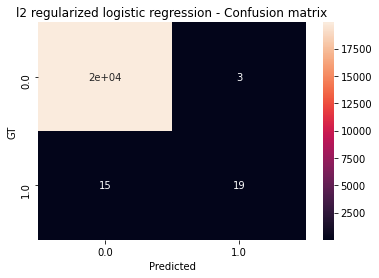

In [ ]:
# lo corremos sobre los datos de validación
y_hat_val = regularized_logistic_regression_model.predict(dataset['X_val'])

# obtenemos la matriz usando pandas y seaborn
df = pd.DataFrame({'GT': dataset['y_val'], 'Predicted': y_hat_val}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True)
ax.set_title('{} - Confusion matrix'.format(long_name))
plt.show()

Vemos que el clasificador practicamente predice todo como perteneciente a la clase 0, y que se confunde bastante cuando debe clasificar las muestras pertenecientes a la clase 1. ¿Cómo puede ser entonces que la métrica que estuvimos viendo diera tan bien?
Bueno, esto es porque el Accuracy pesa de igual manera ambas clases. Necesitamos entonces métricas que sean capaces de estudiar mejor estas proporciones.

¿Qué pasa si medimos la sensitivity y la specificity?

In [ ]:
# calculamos la sensitividad y especificidad del modelo
se = sensitivity(dataset['y_val'], y_hat_val)
sp = specificity(dataset['y_val'], y_hat_val)

print('Sensitivity = {:.4f}'.format(se))
print('Specificity = {:.4f}'.format(sp))

Sensitivity = 0.5588
Specificity = 0.9998


Vemos claramente que nuestro modelo tiene muy buena performance para detectar la clase 0 pero que es terrible para detectar la clase 1: solamente detecta el 55% de los casos!

Recordemos: sensitivity está expresada como $\text{Se} = \frac{\text{TP}}{\text{TP}+\text{FN}}$. A la sensitivity suele conocérsela también como "Recall", y nos expresa la capacidad que tiene el algoritmo de detectar las muestras positivas y no comerse algunas. Alternativamente, existe otra métrica conocida como precision, que nos permite conocer esta misma fracción en función de los falsos positivos: $Pr = \frac{\text{TP}}{\text{TP}+\text{FP}}$. Un modelo con alto recall pero baja precision será muy bueno para detectar la clase positiva pero tendrá muchos falsos positivos. Un modelo con bajo recall pero precision alto será poco hábil para encontrar nuestra clase positiva, y por ende tiene menos falsos positivos.

¿Existe alguna métrica única que nos permita estudiar todo a la vez? Sí, se llama [F1-score](https://en.wikipedia.org/wiki/F1_score), y se calcula como la media armónica entre Pr y Re: $\text{F1} = 2 \cdot \frac{\text{Pr} * \text{Re}}{\text{Pr} + \text{Re}}$. Nos permite conocer qué balance hay entre Pr y Re, y no está afectada por el desbalance de clases ya que no tiene en cuenta a la clase negativa (no mira nunca los TN!).

Otra métrica alternativa es el [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient). Su fórmula es más complicada, pero básicamente nos alcanza con saber que toma valores en el intervalo [-1, 1]. Cuando da +1, el algoritmo es perfecto. Cuando da 0, es un modelo random. Cuando da -1, las respuestas son totalmente inversas a las esperadas.

Calculemos estas métricas sobre nuestro clasificador y veamos qué obtenemos.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics_for_imbalanced_datasets(y, y_hat):
  '''
  Una función para que nos calcule todas las métricas de una
  '''
  # calculamos precision, recall, F1-score y MCC
  pr_value = precision_score(y, y_hat)
  re_value = recall_score(y, y_hat)
  f1_value = f1_score(y, y_hat)
  mcc_value = matthews_corrcoef(y, y_hat)

  return pr_value, re_value, f1_value, mcc_value


# calculamos todas las métricas
pr_standard, re_standard, f1_standard, matthews_standard = compute_metrics_for_imbalanced_datasets(dataset['y_val'], y_hat_val)

print('Precision = {:.4f}'.format(pr_standard))
print('Recall = {:.4f}'.format(re_standard))
print('------------')
print('F1-score = {:.4f}'.format(f1_standard))
print('MCC = {:.4f}'.format(matthews_standard))

Precision = 0.8636
Recall = 0.5588
------------
F1-score = 0.6786
MCC = 0.6943


Seguimos confirmando que nuestro clasificador es terrible: tiene poca capacidad de detectar la clase positiva (sensitivity/recall de 55%), comete varios falsos positivos (precision de 86%) y tiene un balance horrible entre Pr y Re (F1-score de 67%).

Finalmente, así como pudimos estudiar los scores/probabilidades generados por el clasificador en términos de sensitivity/specificity usando curvas ROC, podemos hacer lo propio usando [curvas de precision/recall](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/). También podemos calcular el área debajo de esta curva como un indicador de qué tan bueno es el modelo.

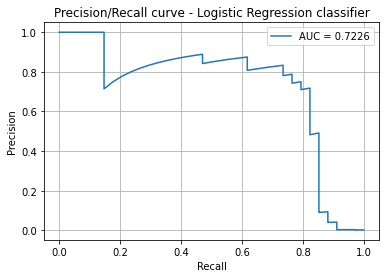

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# nos quedamos con las probabilidades de pertenecer a la clase 1 para cada muestra
# de validación
y_hat_val = regularized_logistic_regression_model.predict_proba(dataset['X_val'])[:,1]

# calculamos los valores para la curva de precision/recall
pr_vals_no_correction, re_vals_no_correction, _ = precision_recall_curve(dataset['y_val'], y_hat_val)
# calculamos el area bajo la curva
AUC_no_correction = auc(re_vals_no_correction, pr_vals_no_correction)

plt.plot(re_vals_no_correction, pr_vals_no_correction)
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve - Logistic Regression classifier')
plt.legend(['AUC = {:.4f}'.format(AUC_no_correction)])
plt.show()

En estas curvas, el mejor resultado es aquel que tiene el vértice en el margen superior derecho (ya no en el izquierdo). A diferencia de la curva ROC, la curva de precision/recall asociada a un modelo aleatorio es más difícil de estimar, dado que solamente tenemos una sola clase involucrada. En cualquier caso, sabemos cómo queremos que de, y queremos además que el área debajo de ella sea lo más cercana a 1 posible.

En conclusión: aunque veamos un accuracy de casi 1, no tenemos garantías de que el modelo sea el correcto si las clases están desbalanceadas. El testeo de calidad debemos hacerlo usando métrias que sean robustas a este tipo de problemas, y esto también cuenta para el model selection!

#### 4.3. Estrategias de corrección

Existen varias formas para poder ayudar a los clasificadores a lidear con datos desbalanceados. Vamos a analizar algunas de ellas



##### 4.3.1. Pesos en la loss function

Los algoritmos que se basan en la minimización de una función de pérdida en general incluyen un parámetro ```class_weight``` que te permiten "pesar" errores al cometer errores para una u otra muestra. 

En general, lo que buscamos siempre es balancear los problemas, dándole más peso a los errores de la clase menos abundante, y siendo más permisivos con los errores de la clase más abundante. De esa forma, y por una cuestión de frecuencias, lograríamos que los errores con la clase menos abundate queden más o menos balanceados respecto a los errores de la(s) otra(s) clase(s).

Una heurística que suele utilizarse es tomar la inversa de la frecuencia de cada clase, estimada a partir de los datos de entrenamiento. Así, cometer errores para la clase 1 sería muchísimo más caro que cometer errores con la clase 0, y obligaríamos al algoritmo a no tentarse a clasificar todo como clase 0. A veces esto puede generar errores de convergencia o hacer que el algoritmo prediga todo como clase 1. En otros casos, puede no tratarse de una solución óptima.

Con la siguiente instrucción podemos calcular automáticamente esos valores.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# calculamos los pesos para cada clase
weighting = compute_class_weight('balanced', np.unique(dataset['y_train']), dataset['y_train'])
print(weighting)

[  0.501 289.398]


Podemos ver que entonces cada error para la clase 0 pagaría un costo de aproximadamente 0.5, mientras que los errores para la clase 1 tendrían un costo asociado de 289.

Otra alternativa es construir estos pesos manualmente. En tal caso, lo que hacemos es pasarle al método de clasificación un parámetro ```class_weight``` con un diccionario de la forma ```{ clase : peso de esa clase }```. Esto claramente nos agrega un nuevo hiperparámetro (cuánto pesar errores de cada clase), que tendríamos que elegir a partir de nuestros datos de validation.

Probemos esto en el modelo de logistic regression. Fíjense que este bloque cambia respecto al que corrimos antes: ahora no hacemos model selection mirando accuracy, lo hacemos optimizando F1-score. Les dejamos dos potenciales balances para que analicen.

Weighted logistic regression classifier with l2 regularization

l2 Log Reg with C=1e-05 --> F1-score=0.2439 - Positive samples=7.0
l2 Log Reg with C=0.0001 --> F1-score=0.6038 - Positive samples=19.0
l2 Log Reg with C=0.001 --> F1-score=0.7812 - Positive samples=30.0
l2 Log Reg with C=0.01 --> F1-score=0.8182 - Positive samples=32.0
l2 Log Reg with C=0.1 --> F1-score=0.8000 - Positive samples=31.0
l2 Log Reg with C=1 --> F1-score=0.8000 - Positive samples=31.0
l2 Log Reg with C=10 --> F1-score=0.8000 - Positive samples=31.0
l2 Log Reg with C=100 --> F1-score=0.8000 - Positive samples=31.0
l2 Log Reg with C=1000 --> F1-score=0.8000 - Positive samples=31.0



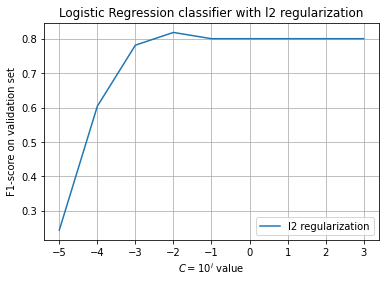


-----------------------
Best C: 0.01
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Unweighted model performance
MCC: 0.6943
F1-score: 0.6786
Precision: 0.8636
Recall: 0.5588


In [ ]:
#class_weight = {0: weighting[0], 1: weighting[1]}
class_weight = {0:1, 1:5}
#class_weight = None

# inicializamos un vector donde guardaremos los valores de F1-score
reg_log_reg_f1_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
reg_log_reg_f1_models = []

# probamos cada valor de C
print('Weighted logistic regression classifier with {} regularization'.format(regularizer))
print('')
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000, class_weight=class_weight)
  reg_log_reg_f1_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(dataset['X_train'], dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su F1-score comparando estas etiquetas con el ground truth
  reg_log_reg_f1_val[i] = f1_score(dataset['y_val'], y_hat_val)
  print('{} Log Reg with C={} --> F1-score={:.4f} - Positive samples={}'.format(regularizer, 10**(C_values[i]), reg_log_reg_f1_val[i], np.sum(y_hat_val)))
print('')

# mostramos un gráfico ilustrando la evolución del F1-score para cada C
plt.plot(C_values, reg_log_reg_f1_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('F1-score on validation set')
plt.title('Logistic Regression classifier with {} regularization'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer)])
plt.show(True)

# identificamos el mejor valor de C a partir del F1-score más alto
C_idx = np.argmax(reg_log_reg_f1_val)
# lo reservamos
class_balanced_regularized_logistic_regression_model = reg_log_reg_f1_models[C_idx]
# lo corremos sobre los datos de validación
y_hat_val = class_balanced_regularized_logistic_regression_model.predict(dataset['X_val'])
y_hat_val_proba = class_balanced_regularized_logistic_regression_model.predict_proba(dataset['X_val'])[:,1]

# calculamos las métricas
pr_weighted, re_weighted, f1_weighted, matthews_weighted = compute_metrics_for_imbalanced_datasets(dataset['y_val'], y_hat_val)

# imprimimos los resultados por pantalla
print('')
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('MCC: {:.4f}'.format(matthews_weighted))
print('F1-score: {:.4f}'.format(f1_weighted))
print('Precision: {:.4f}'.format(pr_weighted))
print('Recall: {:.4f}'.format(re_weighted))
print('-----------------------')
print('Unweighted model performance')
print('MCC: {:.4f}'.format(matthews_standard))
print('F1-score: {:.4f}'.format(f1_standard))
print('Precision: {:.4f}'.format(pr_standard))
print('Recall: {:.4f}'.format(re_standard))


Cuando se utilizan valores tan extremos para penalizar los errores, puede ocurrir que el método overfittee con facilidad (por ejemplo, se vea tentado a clasificar muchas más muestras de las que debería como pertenecientes a la clase 1). En general, en estos casos conviene ampliar los rangos de búsqueda de valores de $C$ y recurrir a valores más bajos.

Por otro lado, vemos que el peso alternativo que proponemos logra incrementar significativamente los valores de F1-score sin afectar notoriamente el overfitting. Estos pesos son arbitrarios, deberíamos hacer todo un proceso de model selection para encontrar la mejor forma de pesar cada muestra. 

Imprimamos las curvas de Precision/Recall, para estudiar cómo cambiaron los resultados.

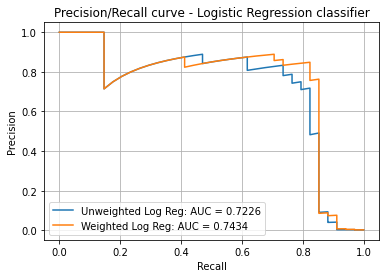

In [ ]:
# calculamos los valores para la curva de precision/recall
pr_vals_weighted, re_vals_weighted, _ = precision_recall_curve(dataset['y_val'], y_hat_val_proba)
# calculamos el area bajo la curva
AUC_weighted = auc(re_vals_weighted, pr_vals_weighted)

plt.plot(re_vals_no_correction, pr_vals_no_correction)
plt.plot(re_vals_weighted, pr_vals_weighted)
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve - Logistic Regression classifier')
plt.legend(['Unweighted Log Reg: AUC = {:.4f}'.format(AUC_no_correction),
            'Weighted Log Reg: AUC = {:.4f}'.format(AUC_weighted)], loc='lower left')
plt.show()

##### 5.3.2 Reducir el número de muestras de la clase mayoritaria

Otra alternativa para corregir el problema es reducir el número de muestras de la clase mayoritaria. Aleatoriamente, podemos elegir muestras de la clase 0 y eliminarlas de nuestros datos de entrenamiento. De esta forma, el algoritmo verá cantidades más o menos similares de datos de una y otra clase, y en consecuencia hacer una mejor interpretación de las distribuciones en el espacio.

Vamos a usar para eso la librería ```imblearn```, que incluye banda de rutinas para preprocesar datos en problemas de clase desbalanceada. Vamos usar la clase [```RandomUnderSampler```](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html), que nos permite eliminar muestras aleatoriamente. Tenemos que ajustar el parámetro ```sampling_strategy```. Si le indicamos ```majority```, reducirá el número de muestras de la clase mayoritaria para que coincida con el de la clase minoritaria. Si indicamos un valor numérico, corresponderá al ratio de muestras minoritarias sobre mayoritarias (por ejemplo, 0.4 indicaría que queremos que un 40% sean de la clase minoritaria y el restante 60% de la mayoritaria).

Veamos cómo estos cambios afectan la performance del algoritmo.

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original training set size: (179427, 30)
New training set size: (620, 30)

Logistic regression classifier with l2 regularization in undersampled dataset
l2 Log Reg with C=1e-05 --> F1-score=0.8254 - Positive samples=29.0
l2 Log Reg with C=0.0001 --> F1-score=0.8308 - Positive samples=31.0
l2 Log Reg with C=0.001 --> F1-score=0.8000 - Positive samples=36.0
l2 Log Reg with C=0.01 --> F1-score=0.2007 - Positive samples=255.0
l2 Log Reg with C=0.1 --> F1-score=0.0960 - Positive samples=612.0
l2 Log Reg with C=1 --> F1-score=0.0673 - Positive samples=887.0
l2 Log Reg with C=10 --> F1-score=0.0644 - Positive samples=928.0
l2 Log Reg with C=100 --> F1-score=0.0646 - Positive samples=926.0
l2 Log Reg with C=1000 --> F1-score=0.0650 - Positive samples=920.0



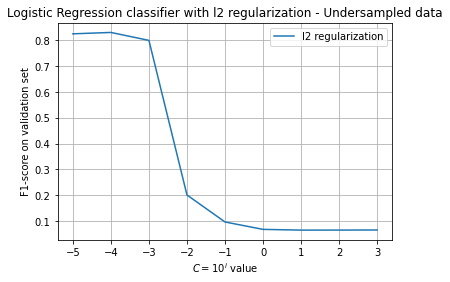


-----------------------
Best C: 0.0001
MCC: 0.8314
F1-score: 0.8308
Precision: 0.8710
Recall: 0.7941
-----------------------
Weighted model performance
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Unweighted model performance
MCC: 0.6943
F1-score: 0.6786
Precision: 0.8636
Recall: 0.5588



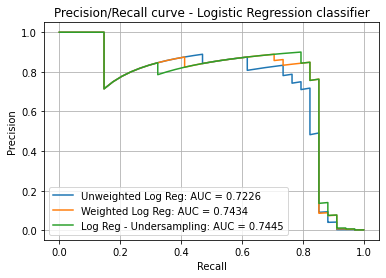

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# elegimos la estrategia de sampling
sampling_strategy = 'majority'
#sampling_strategy = 0.1

# inicializamos el objeto que nos hará el undersampling
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=10)
# # generamos los nuevos datos
undersampled_dataset = dataset.copy()
undersampled_dataset['X_train'], undersampled_dataset['y_train'] = undersample.fit_resample(dataset['X_train'], dataset['y_train'])
print('Original training set size: {}'.format(dataset['X_train'].shape))
print('New training set size: {}'.format(undersampled_dataset['X_train'].shape))
print('')

# inicializamos un vector donde guardaremos los valores de accuracy
undersampled_reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
undersampled_reg_log_reg_models = []

# probamos cada valor de C
print('Logistic regression classifier with {} regularization in undersampled dataset'.format(regularizer))
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000)
  undersampled_reg_log_reg_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(undersampled_dataset['X_train'], undersampled_dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su F1-score comparando estas etiquetas con el ground truth
  undersampled_reg_log_reg_accuracy_val[i] = f1_score(dataset['y_val'], y_hat_val)
  print('{} Log Reg with C={} --> F1-score={:.4f} - Positive samples={}'.format(regularizer, 10**(C_values[i]), undersampled_reg_log_reg_accuracy_val[i], np.sum(y_hat_val)))
print('')

# mostramos un gráfico ilustrando la evolución del F1-score para cada C
plt.plot(C_values, undersampled_reg_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('F1-score on validation set')
plt.title('Logistic Regression classifier with {} regularization - Undersampled data'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer)])
plt.show(True)

# identificamos el mejor valor de C a partir del F1-score más alto
C_idx = np.argmax(undersampled_reg_log_reg_accuracy_val)
# lo reservamos
undersampled_regularized_logistic_regression_model = undersampled_reg_log_reg_models[C_idx]
# lo corremos sobre los datos de validación
y_hat_val = undersampled_regularized_logistic_regression_model.predict(dataset['X_val'])
y_hat_val_proba = undersampled_regularized_logistic_regression_model.predict_proba(dataset['X_val'])[:,1]

# calculamos las métricas
pr_undersampled, re_undersampled, f1_undersampled, matthews_undersampled = compute_metrics_for_imbalanced_datasets(dataset['y_val'], y_hat_val)

# imprimimos los resultados por pantalla
print('')
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('MCC: {:.4f}'.format(matthews_undersampled))
print('F1-score: {:.4f}'.format(f1_undersampled))
print('Precision: {:.4f}'.format(pr_undersampled))
print('Recall: {:.4f}'.format(re_undersampled))
print('-----------------------')
print('Weighted model performance')
print('MCC: {:.4f}'.format(matthews_weighted))
print('F1-score: {:.4f}'.format(f1_weighted))
print('Precision: {:.4f}'.format(pr_weighted))
print('Recall: {:.4f}'.format(re_weighted))
print('-----------------------')
print('Unweighted model performance')
print('MCC: {:.4f}'.format(matthews_standard))
print('F1-score: {:.4f}'.format(f1_standard))
print('Precision: {:.4f}'.format(pr_standard))
print('Recall: {:.4f}'.format(re_standard))
print('')

# calculamos los valores para la curva de precision/recall
pr_vals_under, re_vals_under, _ = precision_recall_curve(dataset['y_val'], y_hat_val_proba)
# calculamos el area bajo la curva
AUC_under = auc(re_vals_under, pr_vals_under)

plt.plot(re_vals_no_correction, pr_vals_no_correction)
plt.plot(re_vals_weighted, pr_vals_weighted)
plt.plot(re_vals_under, pr_vals_under)
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve - Logistic Regression classifier')
plt.legend(['Unweighted Log Reg: AUC = {:.4f}'.format(AUC_no_correction),
            'Weighted Log Reg: AUC = {:.4f}'.format(AUC_weighted),
            'Log Reg - Undersampling: AUC = {:.4f}'.format(AUC_under)], loc='lower left')
plt.show()

Vemos que en este caso la performance mejora significativamente, además de la velocidad del entrenamiento. Para valores de $C$ grandes, la cantidad de muestras positivas predichas por el método crecen notoriamente, lo que en principio indica que reducir demasiado el número de muestras de entrenamiento de la clase 0 puede aumentar bastante el riesgo de overfittear hacia la clase minoritaria.

Si probamos otras proporciones, veremos que este comportamiento puede variar. Así mismo, y dado que las muestras se están descartando aleatoriamente, puede que los modelos/resultados que se obtengan varíen para ejecuciones idénticas de un mismo código.

##### 5.3.3. Replicar muestras de la clase minoritaria

Otra alternativa de corrección es ir por la contraria: incrementar la cantidad de ratos correspondientes a la clase minoritaria. Como obviamente no podemos generar datos nuevos (sería ideal, pero bueno, los datos ya están acá y algo tenemos que hacer con esto), lo que podemos hacer es repetir varias veces las pocas muestras que tenemos para la clase minoritaria. Esto puede entenderse como una forma de *data augmentation*, que verán más adelante en el curso de redes neuronales.

Vamos a usar también una clase de la librería ```imblearn```, en este caso el ```RandomOverSampler```. Su funcionamiento es idéntico al de la clase ```RandomUnderSampler```, solo que en lugar de eliminar muestras repetiremos algunas.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original training set size: (179427, 30)
New training set size: (188072, 30)

Logistic regression classifier with l2 regularization in oversampled dataset
l2 Log Reg with C=1e-05 --> F1-score=0.6038 - Positive samples=19.0
l2 Log Reg with C=0.0001 --> F1-score=0.8182 - Positive samples=32.0
l2 Log Reg with C=0.001 --> F1-score=0.8116 - Positive samples=35.0
l2 Log Reg with C=0.01 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=0.1 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=1 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=10 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=100 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=1000 --> F1-score=0.8169 - Positive samples=37.0



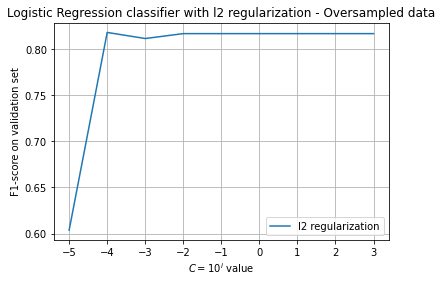


-----------------------
Best C: 0.0001
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Model performance undersampling majority class
MCC: 0.8314
F1-score: 0.8308
Precision: 0.8710
Recall: 0.7941
-----------------------
Weighted model performance
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Unweighted model performance
MCC: 0.6943
F1-score: 0.6786
Precision: 0.8636
Recall: 0.5588



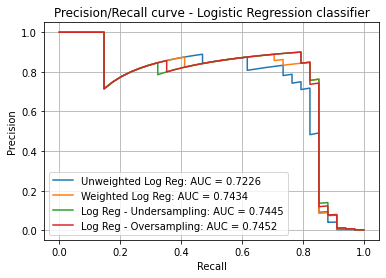

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# elegimos la estrategia de sampling
#sampling_strategy = 'minority'
sampling_strategy = 0.05

# inicializamos el objeto que nos hará el undersampling
oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=10)
# # generamos los nuevos datos
oversampled_dataset = dataset.copy()
oversampled_dataset['X_train'], oversampled_dataset['y_train'] = oversample.fit_resample(dataset['X_train'], dataset['y_train'])
print('Original training set size: {}'.format(dataset['X_train'].shape))
print('New training set size: {}'.format(oversampled_dataset['X_train'].shape))
print('')

# inicializamos un vector donde guardaremos los valores de accuracy
oversampled_reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
oversampled_reg_log_reg_models = []

# probamos cada valor de C
print('Logistic regression classifier with {} regularization in oversampled dataset'.format(regularizer))
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000)
  oversampled_reg_log_reg_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(oversampled_dataset['X_train'], oversampled_dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su F1-score comparando estas etiquetas con el ground truth
  oversampled_reg_log_reg_accuracy_val[i] = f1_score(dataset['y_val'], y_hat_val)
  print('{} Log Reg with C={} --> F1-score={:.4f} - Positive samples={}'.format(regularizer, 10**(C_values[i]), oversampled_reg_log_reg_accuracy_val[i], np.sum(y_hat_val)))
print('')

# mostramos un gráfico ilustrando la evolución del F1-score para cada C
plt.plot(C_values, oversampled_reg_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('F1-score on validation set')
plt.title('Logistic Regression classifier with {} regularization - Oversampled data'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer)])
plt.show(True)

# identificamos el mejor valor de C a partir del F1-score más alto
C_idx = np.argmax(oversampled_reg_log_reg_accuracy_val)
# lo reservamos
oversampled_regularized_logistic_regression_model = oversampled_reg_log_reg_models[C_idx]
# lo corremos sobre los datos de validación
y_hat_val = oversampled_regularized_logistic_regression_model.predict(dataset['X_val'])
y_hat_val_proba = oversampled_regularized_logistic_regression_model.predict_proba(dataset['X_val'])[:,1]

# calculamos las métricas
pr_oversampled, re_oversampled, f1_oversampled, matthews_oversampled = compute_metrics_for_imbalanced_datasets(dataset['y_val'], y_hat_val)

# imprimimos los resultados por pantalla
print('')
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('MCC: {:.4f}'.format(matthews_oversampled))
print('F1-score: {:.4f}'.format(f1_oversampled))
print('Precision: {:.4f}'.format(pr_oversampled))
print('Recall: {:.4f}'.format(re_oversampled))
print('-----------------------')
print('Model performance undersampling majority class')
print('MCC: {:.4f}'.format(matthews_undersampled))
print('F1-score: {:.4f}'.format(f1_undersampled))
print('Precision: {:.4f}'.format(pr_undersampled))
print('Recall: {:.4f}'.format(re_undersampled))
print('-----------------------')
print('Weighted model performance')
print('MCC: {:.4f}'.format(matthews_weighted))
print('F1-score: {:.4f}'.format(f1_weighted))
print('Precision: {:.4f}'.format(pr_weighted))
print('Recall: {:.4f}'.format(re_weighted))
print('-----------------------')
print('Unweighted model performance')
print('MCC: {:.4f}'.format(matthews_standard))
print('F1-score: {:.4f}'.format(f1_standard))
print('Precision: {:.4f}'.format(pr_standard))
print('Recall: {:.4f}'.format(re_standard))
print('')

# calculamos los valores para la curva de precision/recall
pr_vals_over, re_vals_over, _ = precision_recall_curve(dataset['y_val'], y_hat_val_proba)
# calculamos el area bajo la curva
AUC_over = auc(re_vals_over, pr_vals_over)

plt.plot(re_vals_no_correction, pr_vals_no_correction)
plt.plot(re_vals_weighted, pr_vals_weighted)
plt.plot(re_vals_under, pr_vals_under)
plt.plot(re_vals_over, pr_vals_over)
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve - Logistic Regression classifier')
plt.legend(['Unweighted Log Reg: AUC = {:.4f}'.format(AUC_no_correction),
            'Weighted Log Reg: AUC = {:.4f}'.format(AUC_weighted),
            'Log Reg - Undersampling: AUC = {:.4f}'.format(AUC_under),
            'Log Reg - Oversampling: AUC = {:.4f}'.format(AUC_over)], loc='lower left')
plt.show()

Vemos que cuando usamos ```minority``` lo que generamos es un modelo desastrozo, que tiene overfitting por todos lados. Es normal: si repetimos innumerables veces las muestras que tenemos para la clase positiva con el solo propósito de matchear el número de clases negativas, el algoritmo se va a tentar a memorizar esas muestras repetidas para dejar de cometer errores, o va a estimar un decision boundary muy poco realista.

Si usamos una proporción más controlada, los resultados van a mejorar un poco. No obstante, tengamos en cuenta siempre que estamos repitiendo datos, y que eso tiene consecuencias.

##### 5.3.4. SMOTE: Synthetic Minority Oversampling TEchnique

La última alternativa que vamos a ver se la propuso en un paper en el año 2002, y se la conoce como [SMOTE: Synthetic Minority Oversampling TEchnique](https://arxiv.org/abs/1106.1813). Hoy por hoy es una de las que más se utiliza. Hay montones más, pero no llegamos :(

SMOTE propone generar muestras artificiales de la clase minoritaria, que podamos después emplear para agrandar el número de muestras. Es equivalente al oversampling que vimos en la sección 5.3.3, pero en lugar de repetir muestras generamos muestras nuevas, parecidas a las que teníamos.

El algoritmo es algo complejo pero fácil de entender. Se toman las muestras minoritarias y se elige una al azar. A esa muestra se le toman sus $k$ vecinos más cercanos, se toma uno de ellos al azar y se genera una nueva muestra equivalente al promedio de ambas. Este proceso se repite cuantas veces sea necesario hasta generar todas las muestras deseadas.

Por suerte no lo tenemos que programar nosotros, tampoco. Vamos a usar la clase ```SMOTE``` del paquete ```imblearn```. Funciona igual que las que veíamos antes.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original training set size: (179427, 30)
New training set size: (188072, 30)

Logistic regression classifier with l2 regularization and SMOTE in dataset
l2 Log Reg with C=1e-05 --> F1-score=0.6038 - Positive samples=19.0
l2 Log Reg with C=0.0001 --> F1-score=0.8182 - Positive samples=32.0
l2 Log Reg with C=0.001 --> F1-score=0.8286 - Positive samples=36.0
l2 Log Reg with C=0.01 --> F1-score=0.8169 - Positive samples=37.0
l2 Log Reg with C=0.1 --> F1-score=0.7945 - Positive samples=39.0
l2 Log Reg with C=1 --> F1-score=0.7945 - Positive samples=39.0
l2 Log Reg with C=10 --> F1-score=0.7945 - Positive samples=39.0
l2 Log Reg with C=100 --> F1-score=0.7945 - Positive samples=39.0
l2 Log Reg with C=1000 --> F1-score=0.7945 - Positive samples=39.0



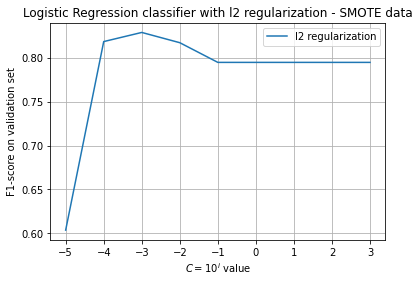


-----------------------
Best C: 0.001
MCC: 0.8286
F1-score: 0.8286
Precision: 0.8056
Recall: 0.8529
-----------------------
Model performance oversampling minority class
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Model performance undersampling majority class
MCC: 0.8314
F1-score: 0.8308
Precision: 0.8710
Recall: 0.7941
-----------------------
Weighted model performance
MCC: 0.8183
F1-score: 0.8182
Precision: 0.8438
Recall: 0.7941
-----------------------
Unweighted model performance
MCC: 0.6943
F1-score: 0.6786
Precision: 0.8636
Recall: 0.5588



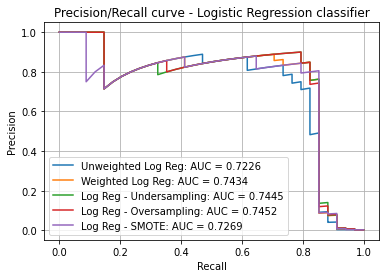

In [ ]:
from imblearn.over_sampling import SMOTE

# inicializamos el objeto que nos hará el undersampling
oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=10, k_neighbors=5)
# # generamos los nuevos datos
smote_dataset = dataset.copy()
smote_dataset['X_train'], smote_dataset['y_train'] = oversample.fit_resample(dataset['X_train'], dataset['y_train'])
print('Original training set size: {}'.format(dataset['X_train'].shape))
print('New training set size: {}'.format(smote_dataset['X_train'].shape))
print('')

# inicializamos un vector donde guardaremos los valores de accuracy
smote_reg_log_reg_accuracy_val = np.zeros(len(C_values))
# inicializamos también una lista para guardar cada modelo que entrenemos
smote_reg_log_reg_models = []

# probamos cada valor de C
print('Logistic regression classifier with {} regularization and SMOTE in dataset'.format(regularizer))
for i in range(len(C_values)):
  # inicializamos el modelo
  model = LogisticRegression(penalty=regularizer, fit_intercept=True, C=10**(C_values[i]), solver=best_solver, max_iter=1000)
  smote_reg_log_reg_models.append(model)
  # lo entrenamos sobre los datos de entrenamiento
  model.fit(smote_dataset['X_train'], smote_dataset['y_train'])
  # lo corremos sobre los datos de validación
  y_hat_val = model.predict(dataset['X_val'])
  # y evaluamos su F1-score comparando estas etiquetas con el ground truth
  smote_reg_log_reg_accuracy_val[i] = f1_score(dataset['y_val'], y_hat_val)
  print('{} Log Reg with C={} --> F1-score={:.4f} - Positive samples={}'.format(regularizer, 10**(C_values[i]), smote_reg_log_reg_accuracy_val[i], np.sum(y_hat_val)))
print('')

# mostramos un gráfico ilustrando la evolución del F1-score para cada C
plt.plot(C_values, smote_reg_log_reg_accuracy_val)
plt.xlabel('$C=10^i$ value')
plt.grid()
plt.ylabel('F1-score on validation set')
plt.title('Logistic Regression classifier with {} regularization - SMOTE data'.format(regularizer))
plt.legend(['{} regularization'.format(regularizer)])
plt.show(True)

# identificamos el mejor valor de C a partir del F1-score más alto
C_idx = np.argmax(smote_reg_log_reg_accuracy_val)
# lo reservamos
smote_regularized_logistic_regression_model = smote_reg_log_reg_models[C_idx]
# lo corremos sobre los datos de validación
y_hat_val = smote_regularized_logistic_regression_model.predict(dataset['X_val'])
y_hat_val_proba = smote_regularized_logistic_regression_model.predict_proba(dataset['X_val'])[:,1]

# calculamos las métricas
pr_smote, re_smote, f1_smote, matthews_smote = compute_metrics_for_imbalanced_datasets(dataset['y_val'], y_hat_val)

# imprimimos los resultados por pantalla
print('')
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('MCC: {:.4f}'.format(matthews_smote))
print('F1-score: {:.4f}'.format(f1_smote))
print('Precision: {:.4f}'.format(pr_smote))
print('Recall: {:.4f}'.format(re_smote))
print('-----------------------')
print('Model performance oversampling minority class')
print('MCC: {:.4f}'.format(matthews_oversampled))
print('F1-score: {:.4f}'.format(f1_oversampled))
print('Precision: {:.4f}'.format(pr_oversampled))
print('Recall: {:.4f}'.format(re_oversampled))
print('-----------------------')
print('Model performance undersampling majority class')
print('MCC: {:.4f}'.format(matthews_undersampled))
print('F1-score: {:.4f}'.format(f1_undersampled))
print('Precision: {:.4f}'.format(pr_undersampled))
print('Recall: {:.4f}'.format(re_undersampled))
print('-----------------------')
print('Weighted model performance')
print('MCC: {:.4f}'.format(matthews_weighted))
print('F1-score: {:.4f}'.format(f1_weighted))
print('Precision: {:.4f}'.format(pr_weighted))
print('Recall: {:.4f}'.format(re_weighted))
print('-----------------------')
print('Unweighted model performance')
print('MCC: {:.4f}'.format(matthews_standard))
print('F1-score: {:.4f}'.format(f1_standard))
print('Precision: {:.4f}'.format(pr_standard))
print('Recall: {:.4f}'.format(re_standard))
print('')

# calculamos los valores para la curva de precision/recall
pr_vals_smote, re_vals_smote, _ = precision_recall_curve(dataset['y_val'], y_hat_val_proba)
# calculamos el area bajo la curva
AUC_smote = auc(re_vals_smote, pr_vals_smote)

plt.plot(re_vals_no_correction, pr_vals_no_correction)
plt.plot(re_vals_weighted, pr_vals_weighted)
plt.plot(re_vals_under, pr_vals_under)
plt.plot(re_vals_over, pr_vals_over)
plt.plot(re_vals_smote, pr_vals_smote)
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve - Logistic Regression classifier')
plt.legend(['Unweighted Log Reg: AUC = {:.4f}'.format(AUC_no_correction),
            'Weighted Log Reg: AUC = {:.4f}'.format(AUC_weighted),
            'Log Reg - Undersampling: AUC = {:.4f}'.format(AUC_under),
            'Log Reg - Oversampling: AUC = {:.4f}'.format(AUC_over),
            'Log Reg - SMOTE: AUC = {:.4f}'.format(AUC_smote)], loc='lower left')
plt.show()

### 5. Problemas multiclase

En los problemas multiclase buscamos modelos capaces de predecir no una variable dicotómica (0 o 1), si no una categórica (0, 1, ..., K). Los algoritmos con los que estamos trabajando, originalmente concebidos para problemas binarios, tienen extensiones que nos permiten atacar problemas multiclase.

![](https://utkuufuk.com/2018/06/03/one-vs-all-classification/one-vs-all.png)

Vamos a analizar esos algoritmos en el contexto de un nuevo problema, utilizando el [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). Utilizado comunmente en la literatura de Pattern Recognition, este conjunto de datos nos provee 150 muestras correspondientes a diferentes medidas de distintas flores de Iris, clasificadas en 3 clases (50 muestras por clase): Iris Setosa, Iris Versicolour e Iris Virginica. Los datos están disponibles en Sklearn, así que podemos accederlos directamente.





In [ ]:
from sklearn.datasets import load_iris

# cargamos el conjunto de datos
data = load_iris()

# imprimimos el tamaño del data set para chequear que hayamos cargado todo bien
X = data['data']
y = data['target']
print('======================')
print('ORIGINAL IRIS DATASET')
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))
print('Feature names: {}'.format(data.feature_names))
print('Classes: {}'.format(np.unique(y)))
print('Target names: {}'.format(data.target_names))
print('% samples per class')
for i in range(len(np.unique(y))):
  print('--> {} : {:2.2f}%'.format(i, np.sum(y==i)/y.size*100))
print('======================')


ORIGINAL IRIS DATASET
Num samples: 150
Num features: 4
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: [0 1 2]
Target names: ['setosa' 'versicolor' 'virginica']
% samples per class
--> 0 : 33.33%
--> 1 : 33.33%
--> 2 : 33.33%


Vemos que efectivamente tenemos 4 features para cada muestra, y que además tenemos 3 etiquetas posibles en este caso. Los datos además están distribuidos en igual cantidad por clase. 

150 muestras es quizá un número demasiado chico para entrenar y evaluar un clasificador usando las típicas particiones de train/val/test: muy probablemente las estimaciones de performance que obtendríamos para algunas configuraciones no serían tan confiables, y un clasificador entrenado en menos del 70% de estos datos tampoco sería muy fiable en producción.

Para sortear esta dificultad, entonces, vamos a estudiar nuestros algoritmos de clasificación multiclase usando k-fold cross-validation. En particular vamos a usar siempre la misma partición, con $k=5$, ya que 150 es múltiplo de 5. Así, nos quedarían conjuntos de entrenamiento de 120 muestras y de test de 30. Además, vamos a estratificar el sampleo, para asegurarnos idéntica proporción de clases entre los folds de test y los de entrenamiento.

Una vez que hayamos encontrado el mejor modelo para nuestros datos usando cross-validation, deberíamos entrenarlo una última vez usando absolutamente todos los datos que tenemos, y deployaríamos ese modelo final en producción.

Preparemos los datos para eso, entonces. Recuerden que en estos casos es totalmente legal estandarizar todos los datos con media y desvío estimados a partir de todos.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# inicializamos la estructura donde vamos a guardar nuestro dataset reformateado
dataset = dict()

# asignamos los campos que ya podemos asignar
dataset['feature_labels'] = data.feature_names
dataset['target_names'] = list(data.target_names)
# calculamos media y desvío
dataset['mu'] = np.mean(X, axis=0)
dataset['sigma'] = np.std(X, axis=0)
# guardamos los datos estandarizados y sus etiquetas
dataset['X'] = (X - dataset['mu']) / dataset['sigma']
dataset['y'] = y
# generamos una partición de cross validation estratificado
dataset['cross-val-partition'] = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
print(dataset['cross-val-partition'])

StratifiedKFold(n_splits=5, random_state=10, shuffle=True)


El problema multiclase definido en este nuevo dataset nos viene genial para ver cómo se adaptan los algoritmos que veníamos viendo a este tipo de problemas. Vamos a ir uno por uno.

#### 5.1. Random Forest

El modelo de Random Forest está concebido desde sus inicios para trabajar en problemas multiclase. Las predicciones de cada árbol de decisión del bosque pertenecerán a alguna de las clases objetivo (0, 1 o 2, en el ejemplo del dataset Iris), y tomaremos la que más se repita como respuesta del algoritmo. 

Vamos a entrenar y evaluar nuestro modelo de Random Forest en este nuevo conjunto de datos, usando cross-validation. Para ellos analizaremos distintas cantidades de árboles, y estudiaremos como cambian el Accuracy promedio por cada fold, además de su desvío estándar. Lo ideal es quedarnos siempre con el número de árboles que reporta un accuracy promedio más alto, y un desvío estándar más bajo (es decir, el mejor modelo y a la vez el más estable).

Random Forest Classifier
-----------------------
RF with T=5 --> Acc=0.9533+-0.0400
RF with T=10 --> Acc=0.9467+-0.0499
RF with T=25 --> Acc=0.9533+-0.0499
RF with T=50 --> Acc=0.9533+-0.0499
-----------------------
Best T: 25
Average accuracy: 0.9533+-0.0499
-----------------------


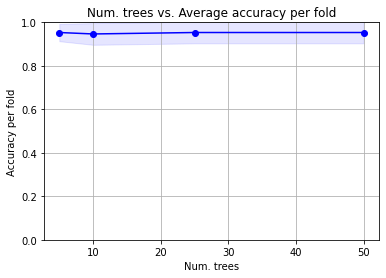

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# numero de arboles
num_trees = [5, 10, 25, 50]

# arreglo para ir guardando los valores de accuracy
rf_mean_accuracy = np.zeros(len(num_trees))
rf_std_accuracy = np.zeros(len(num_trees))

# iteramos por cada numero de arboles
i = 0
print('Random Forest Classifier')
print('-----------------------')
for N in num_trees:
  # definimos el modelo
  model = RandomForestClassifier(n_estimators=N, random_state=18)
  # usamos cross validation para evaluar la performance en cada fold
  accuracy_per_fold = cross_val_score(model, 
                                      dataset['X'], dataset['y'], 
                                      cv=dataset['cross-val-partition'], 
                                      scoring='accuracy')
  # tomamos los valores promedio de accuracy, y tmb el desvío
  rf_mean_accuracy[i] = np.mean(accuracy_per_fold)
  rf_std_accuracy[i] = np.std(accuracy_per_fold)
  # imprimimos
  print('RF with T={} --> Acc={:.4f}+-{:.4f}'.format(N, rf_mean_accuracy[i], rf_std_accuracy[i]))
  i=i+1

# identificamos el mejor valor de T a partir del accuracy más alto
T_idx = np.argmax(rf_mean_accuracy)
best_rf_performance = dict()
best_rf_performance['mean']=rf_mean_accuracy[T_idx]
best_rf_performance['std']=rf_std_accuracy[T_idx]
# imprimimos los resultados por pantalla
print('-----------------------')
print('Best T: {}'.format(num_trees[T_idx]))
print('Average accuracy: {:.4f}+-{:.4f}'.format(best_rf_performance['mean'], best_rf_performance['std']))
print('-----------------------')

# mostramos un gráfico ilustrando la evolución del accuracy para cada T
fig, ax = plt.subplots()
ax.plot(num_trees, rf_mean_accuracy,'-bo')
ax.fill_between(num_trees, (rf_mean_accuracy-rf_std_accuracy), (rf_mean_accuracy+rf_std_accuracy), color='b', alpha=.1)
ax.set_ylim(0.0, 1)
ax.set_xlabel('Num. trees')
ax.set_ylabel('Accuracy per fold')
ax.set_title('Num. trees vs. Average accuracy per fold')
ax.grid(True)

Noten que la performance del algoritmo es bastante estable, con un mínimo pico para $T=25$. Si quisiéramos, podríamos también mirar los resultados que obtenemos en cada uno de los folds. Hagámoslo para el modelo que vimos que es óptimo.



In [ ]:
from sklearn.model_selection import cross_val_predict

# inicializamos el modelo
model = RandomForestClassifier(n_estimators=num_trees[T_idx], random_state=18)
# usamos cross validation para obtener las predicciones en cada fold
predictions_per_fold = cross_val_predict(model, 
                                         dataset['X'], dataset['y'], 
                                         cv=dataset['cross-val-partition'])
# y podríamos compararlo con las etiquetas que tenemos
print('Predictions: {}'.format(predictions_per_fold))
print('Ground truth labels: {}'.format(dataset['y']))
print('Agreement: {}'.format(predictions_per_fold == dataset['y']))

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Ground truth labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Agreement: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

El accuracy nos mide las coincidencias entre las etiquetas esperadas y las predichas. Si quisiéramos estudiar qué clases nuestro modelo confunde con cuáles, deberíamos ir mirando una por una las respuestas y compararlas. Una locura. Hay una forma cuantitativa de hacer esto, utilizando las famosas [matrices de confusión](https://en.wikipedia.org/wiki/Confusion_matrix). En el siguiente ejemplo mostramos cómo obtener matrices de confusión utilizando Sklearn (la forma más fácil) y usando Pandas y Seaborn (la forma más bonita).

Confusion matrix using Numpy:
[[50  0  0]
 [ 0 46  4]
 [ 0  3 47]]

Confusion matrix using Pandas and Seaborn:


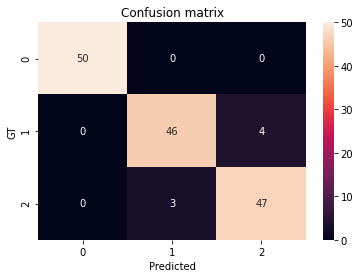

In [ ]:
from sklearn.metrics import confusion_matrix

# obtenemos la matriz de confusión usando sklearn
conf_mat = confusion_matrix(dataset['y'], predictions_per_fold, [0, 1, 2])

print('Confusion matrix using Numpy:')
print(conf_mat)
print('')


import pandas as pd
import seaborn as sn

# obtenemos la matriz usando pandas y seaborn
print('Confusion matrix using Pandas and Seaborn:')
df = pd.DataFrame({'GT': dataset['y'], 'Predicted': predictions_per_fold}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True)
ax.set_title('Confusion matrix')
plt.show()

Podemos ver que los resultados son en principio muy buenos. En la diagonal (donde se grafican las coincidencias) vemos que en la mayoría de los casos nuestro algoritmo predice lo que esperábamos. Solamente comete 3 errores para muestras de la clase 2 (a las que predice como parte de la clase 3) y 4 errores para muestras de la clase 1 (a la que predice como clase 2). Podríamos decir, entonces, que nuestro clasificador multiclase es perfecto (en nuestros datos, al menos) para discernir la clase 0 del resto, pero que comete algunos errores y confunde la clase 2 con la 1 (y viceversa).

#### 5.2. kNN

El modelo de k-Nearest Neighbors también puede aplicarse en problemas multiclase sin requerir ninguna modificación extraña. El único cambio que se manifiesta es que ahora, al momento de elegir qué clase asignar, tendremos vecinos que pueden pertenecer a más de solamente 2 categorías.

Vamos a probarlo en estos nuevos datos que estamos utilizando, siempre usando cross-validation y probando diferentes valores de K.

k Nearest Neighbors
-----------------------
kNN with K=3 --> Acc=0.9333+-0.0558
kNN with K=5 --> Acc=0.9533+-0.0499
kNN with K=7 --> Acc=0.9467+-0.0542
kNN with K=9 --> Acc=0.9600+-0.0389
kNN with K=11 --> Acc=0.9600+-0.0327
kNN with K=13 --> Acc=0.9667+-0.0422
kNN with K=15 --> Acc=0.9600+-0.0389
-----------------------
Best K: 13
Average accuracy: 0.9667+-0.0422
-----------------------


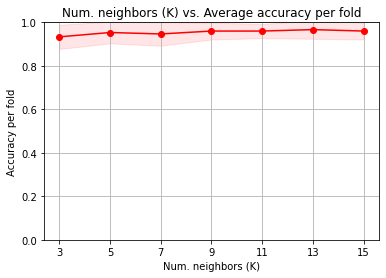

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# número de vecinos para analizar
K_values = [3, 5, 7, 9, 11, 13, 15]

# arreglo para ir guardando los valores de accuracy
knn_mean_accuracy = np.zeros(len(K_values))
knn_std_accuracy = np.zeros(len(K_values))

# iteramos por cada valor de K
i = 0
print('k Nearest Neighbors')
print('-----------------------')
for k in K_values:
  # definimos el modelo
  model = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
  # usamos cross validation para evaluar la performance en cada fold
  accuracy_per_fold = cross_val_score(model, 
                                      dataset['X'], dataset['y'], 
                                      cv=dataset['cross-val-partition'], 
                                      scoring='accuracy')
  # tomamos los valores promedio de accuracy, y tmb el desvío
  knn_mean_accuracy[i] = np.mean(accuracy_per_fold)
  knn_std_accuracy[i] = np.std(accuracy_per_fold)
  # imprimimos
  print('kNN with K={} --> Acc={:.4f}+-{:.4f}'.format(k, knn_mean_accuracy[i], knn_std_accuracy[i]))
  i=i+1

# identificamos el mejor valor de K a partir del accuracy más alto
K_idx = np.argmax(knn_mean_accuracy)
best_knn_performance = dict()
best_knn_performance['mean']=knn_mean_accuracy[K_idx]
best_knn_performance['std']=knn_std_accuracy[K_idx]
# imprimimos los resultados por pantalla
print('-----------------------')
print('Best K: {}'.format(K_values[K_idx]))
print('Average accuracy: {:.4f}+-{:.4f}'.format(knn_mean_accuracy[K_idx], knn_std_accuracy[K_idx]))
print('-----------------------')

# mostramos un gráfico ilustrando la evolución del accuracy para cada K
fig, ax = plt.subplots()
ax.plot(K_values, knn_mean_accuracy,'-ro')
ax.fill_between(K_values, (knn_mean_accuracy-knn_std_accuracy), (knn_mean_accuracy+knn_std_accuracy), color='r', alpha=.1)
ax.set_ylim(0.0, 1)
ax.set_xlabel('Num. neighbors (K)')
ax.set_ylabel('Accuracy per fold')
ax.set_xticks(K_values)
ax.set_title('Num. neighbors (K) vs. Average accuracy per fold')
ax.grid(True)

Por los resultados que obtuvimos, vemos que usando K=13 vecinos obtenemos la mejor performance, incluso superando al Random Forest en su desempeño promedio.

Podríamos generar también la matriz de confusión, para ver para qué clases éste algoritmo anda mejor que el Random Forest:

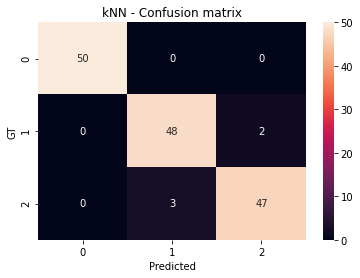

In [ ]:
# inicializamos el modelo
model = KNeighborsClassifier(n_neighbors=K_values[K_idx], algorithm='brute')
# usamos cross validation para obtener las predicciones en cada fold
predictions_per_fold = cross_val_predict(model, 
                                         dataset['X'], dataset['y'], 
                                         cv=dataset['cross-val-partition'])

# obtenemos la matriz usando pandas y seaborn
df = pd.DataFrame({'GT': dataset['y'], 'Predicted': predictions_per_fold}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True)
ax.set_title('kNN - Confusion matrix')
plt.show()

Ahora vemos que el kNN es capaz de cometer 2 errores menos cuando las muestras de entrada son de clase 1 (el RF clasificaba erroneamente a 4 muestras de esa clase como clase 2, y éste lo hace solamente con 2).

#### 5.3. Adaptando modelos lineales: OVR (One Vs. the Rest)

Los modelos lineales con los que estuvimos trabajando (es decir, Regresión Logística y la SVM) pueden adaptarse para resolver un problema multiclase con K clases (1, 2, ..., K). La solución más simple de todas es la de entrenar K clasificadores binarios que resuelvan problemas binarios del tipo clase i vs. todas las demás. Este enfoque se conoce como OVR (One Vs. the Rest), y aunque funciona muy bien en algunos casos, tiene la particularidad de requerir K entrenamientos de modelos en lugar de uno solo. En la siguiente figura vemos que tendremos, para este ejemplo, 3 modelos, uno por cada una de las clases:

![](https://www.oreilly.com/library/view/apache-spark-2x/9781783551606/assets/5e71c32f-8503-49e6-a842-4e8b0b2e7050.png)

Vamos a entrenar un modelo de regresión logística bajo la metodología OVR. La forma de hacerlo en Sklearn es muy simple, basta con indicar el parámetro ```multi_class = 'ovr'```. Tengan en cuenta que, en este caso, necesitamos usar el ```solver = 'liblinear'```, ya que los demás optimizadores no saben cómo resolver un problema OVR. Internamente, la función ```fit``` entrenará 3 modelos OVR, y al predecir la función ```predict``` nos retornará la clase que haya sido observada por el modelo correspondiente. También vamos a generar la matriz de confusión, para estudiar las propeidades del modelo resultante.

OVR L2 regularized Logistic Regression
-----------------------
logreg with C=0.001 --> Acc=0.8133+-0.0581
logreg with C=0.01 --> Acc=0.8267+-0.0712
logreg with C=0.1 --> Acc=0.8333+-0.0760
logreg with C=1 --> Acc=0.9067+-0.0646
logreg with C=10 --> Acc=0.9467+-0.0452
logreg with C=100 --> Acc=0.9533+-0.0499
logreg with C=1000 --> Acc=0.9600+-0.0389
logreg with C=10000 --> Acc=0.9600+-0.0389
logreg with C=100000 --> Acc=0.9533+-0.0499
-----------------------
Best C: 1000
Average accuracy: 0.9600+-0.0389
-----------------------


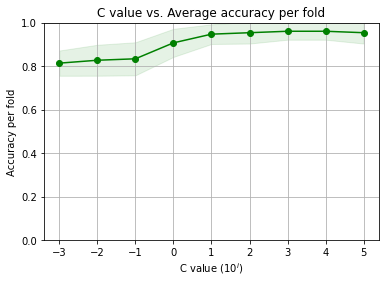

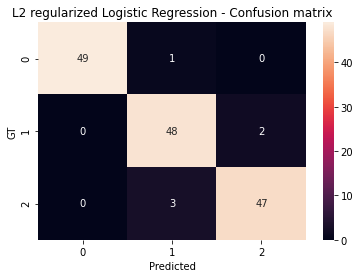

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# elegimos el clasificador
classifier = 'logreg'
#classifier = 'svm'

# le ponemos un nombre largo
if classifier == 'logreg':
  long_name = 'L2 regularized Logistic Regression'
elif classifier == 'svm':
  long_name = 'Support Vector Machine classifier'

# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3, 4, 5]

# arreglo para ir guardando los valores de accuracy
linear_classifier_mean_accuracy = np.zeros(len(C_values))
linear_classifier_std_accuracy = np.zeros(len(C_values))
linear_classifier_models = []

# iteramos por cada valor de C
i = 0
print('OVR {}'.format(long_name))
print('-----------------------')
for c_idx in C_values:
  # definimos el modelo
  if classifier == 'logreg':
    model = LogisticRegression(penalty='l2', fit_intercept=True, C=10**c_idx, solver='liblinear', multi_class='ovr')
  elif classifier == 'svm':
    model = LinearSVC(C=10**c_idx, penalty='l2', loss='hinge', multi_class='ovr', fit_intercept=True, max_iter=150000)
  linear_classifier_models.append(model)
  # usamos cross validation para evaluar la performance en cada fold
  accuracy_per_fold = cross_val_score(model, 
                                      dataset['X'], dataset['y'], 
                                      cv=dataset['cross-val-partition'], 
                                      scoring='accuracy')
  # tomamos los valores promedio de accuracy, y tmb el desvío
  linear_classifier_mean_accuracy[i] = np.mean(accuracy_per_fold)
  linear_classifier_std_accuracy[i] = np.std(accuracy_per_fold)
  # imprimimos
  print('{} with C={} --> Acc={:.4f}+-{:.4f}'.format(classifier, 10**c_idx, linear_classifier_mean_accuracy[i], linear_classifier_std_accuracy[i]))
  i=i+1

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(linear_classifier_mean_accuracy)
best_linear_classifier_performance = dict()
best_linear_classifier_performance['classifier']=classifier
best_linear_classifier_performance['C']=10**C_values[C_idx]
best_linear_classifier_performance['mean']=linear_classifier_mean_accuracy[K_idx]
best_linear_classifier_performance['std']=linear_classifier_std_accuracy[K_idx]
# imprimimos los resultados por pantalla
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Average accuracy: {:.4f}+-{:.4f}'.format(linear_classifier_mean_accuracy[C_idx], linear_classifier_std_accuracy[C_idx]))
print('-----------------------')

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
fig, ax = plt.subplots()
ax.plot(C_values, linear_classifier_mean_accuracy,'-go')
ax.fill_between(C_values, (linear_classifier_mean_accuracy-linear_classifier_std_accuracy), (linear_classifier_mean_accuracy+linear_classifier_std_accuracy), color='g', alpha=.1)
ax.set_ylim(0.0, 1)
ax.set_xlabel('C value ($10^{i}$)')
ax.set_ylabel('Accuracy per fold')
ax.set_xticks(C_values)
ax.set_title('C value vs. Average accuracy per fold')
ax.grid(True)
plt.show()

# usamos cross validation para obtener las predicciones en cada fold
predictions_per_fold = cross_val_predict(linear_classifier_models[C_idx], 
                                         dataset['X'], dataset['y'], 
                                         cv=dataset['cross-val-partition'])

# obtenemos la matriz usando pandas y seaborn
df = pd.DataFrame({'GT': dataset['y'], 'Predicted': predictions_per_fold}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True)
ax.set_title('{} - Confusion matrix'.format(long_name))
plt.show()

Cualquier clasificador lineal suele ofrecernos la posibilidad de ser entrenado bajo este esquema. Por ejemplo, el ```LinearSVC``` de ```sklearn.svm``` tiene también el parámetro ```multiclass```, que podemos setear en ```multiclass='ovr'``` para reproducir este comportamiento. Si cambian el nombre del clasificador arriba, el código lo va a probar por sí solo.

Internamente, lo que ocurre al utilizar el método ```fit``` es que se entrenan múltiples versiones del mismo clasificador, una para cada problema OVR, usando exactamente la misma configuración de hiperparámetros que seleccionemos. De esta forma, internamente el clasificador estará en realidad formado por una serie de clasificadores binarios, que se aplicarán conjuntamente y de manera transparente al usuario al momento de llamar a ```predict```.

Aunque esta idea puede resultar bastante intuitiva, lamentablemente es bastante subóptima: en lugar de estudiar las relaciones entre las features y las diferentes clases, lo hacemos solamente analizando pares, impidiéndonos hacer un mejor aprovechamiento de la información intrínseca en los datos.

#### 5.4. Softmax Regression

Cuando hacemos clasificación multiclase usando un regresor logístico, la posta es recurrir a lo que se conoce como "Softmax Regression". Bajo este enfoque, en lugar de aprender los modelos lineales por separado, los aprendemos todos al mismo tiempo. 

En lugar de tener un vector de pesos $\theta$ que multiplique a nuestras features, ahora tenemos una serie de vectores $\theta^{(k)}$, uno por cada clase $k$. Apilándolos uno debajo del otro, obtendríamos una matriz $\Theta$ de tamaño $k \times d$ ($k$ filas, una por cada clase, y $d$ columnas, una por cada feature), que multiplicada por nuestro vector de características $\mathbf{x}$ nos daría un vector $\mathbf{y}$ de tamaño $k \times 1$, donde tendríamos los scores para cada una de las $k$ clases. Aplicando alguna función sobre ese vector de scores, podríamos convertirlos en probabilidades $p(y=i | \mathbf{x})$ (es decir, la probabilidad de que nuestra muestar $\mathbf{x}$ pertenezca a la clase $i$).

Claramente la función $g(z)$ (la sigmoid) que usábamos antes ya no nos rinde para lograr esas probabilidades que buscamos, porque ahora lo que necesitamos no es que un único valor nos quede entre [0, 1] si no que todos los $k$ valores estén en ese intervalo. Además, necesitamos que sumen 1, ya que cada valor debe representar la probabilidad de pertenecer a la clase $k$. Para eso empleamos una nueva *función de activación*, conocida como softmax, cuya forma es:
$p(i|\mathbf{x}) = \frac{e^{{\theta^{i}}^T}\mathbf{x}}{\sum_j e^{{\theta^{j}}^T}\mathbf{x}}$. Utilizando entonces la función de pérdida original que teníamos, podemos entrenar todos los modelos a la vez, y obtener la clase en tiempo de test simplemente resolviendo $\hat{y} = \text{argmax}_i p(i|\mathbf{x})$ (es decir, asignamos la clase para la que nuestro clasificador nos da la mayor probabilidad).

Vamos a entrenar ese clasificador y ver qué pasa:

Crammer-Singer Support Vector Machine classifier
-----------------------
svm with C=0.001 --> Acc=0.7067+-0.0389
svm with C=0.01 --> Acc=0.7267+-0.0573
svm with C=0.1 --> Acc=0.9533+-0.0452
svm with C=1 --> Acc=0.9600+-0.0389
svm with C=10 --> Acc=0.9533+-0.0400
svm with C=100 --> Acc=0.9667+-0.0298
svm with C=1000 --> Acc=0.9467+-0.0542


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

svm with C=10000 --> Acc=0.9467+-0.0542


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


svm with C=100000 --> Acc=0.9267+-0.0490
-----------------------
Best C: 100
Average accuracy: 0.9667+-0.0298
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


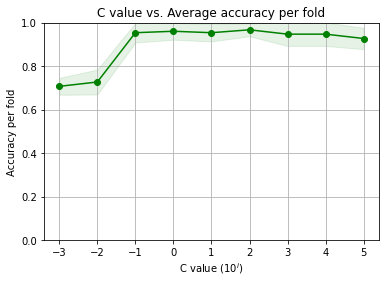

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

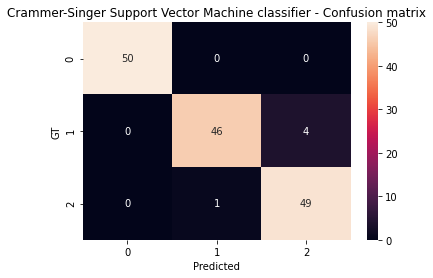

In [ ]:
# elegimos el clasificador
#classifier = 'logreg'
classifier = 'svm'

# le ponemos un nombre largo
if classifier == 'logreg':
  long_name = 'Softmax L2 regularized Logistic Regression'
elif classifier == 'svm':
  long_name = 'Crammer-Singer Support Vector Machine classifier'

# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3, 4, 5]

# arreglo para ir guardando los valores de accuracy
linear_classifier_mean_accuracy = np.zeros(len(C_values))
linear_classifier_std_accuracy = np.zeros(len(C_values))
linear_classifier_models = []

# iteramos por cada valor de C
i = 0
print(long_name)
print('-----------------------')
for c_idx in C_values:
  # definimos el modelo
  if classifier == 'logreg':
    model = LogisticRegression(penalty='l2', fit_intercept=True, C=10**c_idx, solver='newton-cg', multi_class='multinomial')
  elif classifier == 'svm':
    model = LinearSVC(C=10**c_idx, penalty='l2', loss='hinge', multi_class='crammer_singer', fit_intercept=True, max_iter=15000)
  linear_classifier_models.append(model)
  # usamos cross validation para evaluar la performance en cada fold
  accuracy_per_fold = cross_val_score(model, 
                                      dataset['X'], dataset['y'], 
                                      cv=dataset['cross-val-partition'], 
                                      scoring='accuracy')
  # tomamos los valores promedio de accuracy, y tmb el desvío
  linear_classifier_mean_accuracy[i] = np.mean(accuracy_per_fold)
  linear_classifier_std_accuracy[i] = np.std(accuracy_per_fold)
  # imprimimos
  print('{} with C={} --> Acc={:.4f}+-{:.4f}'.format(classifier, 10**c_idx, linear_classifier_mean_accuracy[i], linear_classifier_std_accuracy[i]))
  i=i+1

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(linear_classifier_mean_accuracy)
best_linear_classifier_performance = dict()
best_linear_classifier_performance['classifier']=classifier
best_linear_classifier_performance['C']=10**C_values[C_idx]
best_linear_classifier_performance['mean']=linear_classifier_mean_accuracy[K_idx]
best_linear_classifier_performance['std']=linear_classifier_std_accuracy[K_idx]
# imprimimos los resultados por pantalla
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Average accuracy: {:.4f}+-{:.4f}'.format(linear_classifier_mean_accuracy[C_idx], linear_classifier_std_accuracy[C_idx]))
print('-----------------------')

# mostramos un gráfico ilustrando la evolución del accuracy para cada C
fig, ax = plt.subplots()
ax.plot(C_values, linear_classifier_mean_accuracy,'-go')
ax.fill_between(C_values, (linear_classifier_mean_accuracy-linear_classifier_std_accuracy), (linear_classifier_mean_accuracy+linear_classifier_std_accuracy), color='g', alpha=.1)
ax.set_ylim(0.0, 1)
ax.set_xlabel('C value ($10^{i}$)')
ax.set_ylabel('Accuracy per fold')
ax.set_xticks(C_values)
ax.set_title('C value vs. Average accuracy per fold')
ax.grid(True)
plt.show()

# usamos cross validation para obtener las predicciones en cada fold
predictions_per_fold = cross_val_predict(linear_classifier_models[C_idx], 
                                         dataset['X'], dataset['y'], 
                                         cv=dataset['cross-val-partition'])

# obtenemos la matriz usando pandas y seaborn
df = pd.DataFrame({'GT': dataset['y'], 'Predicted': predictions_per_fold}, columns=['GT','Predicted'])
conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)
ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True)
ax.set_title('{} - Confusion matrix'.format(long_name))
plt.show()

De igual manera, la SVM puede adaptarse utilizando una extensión de la función de pérdida original, la Hinge Loss, propuesta por Crammer y Singer en un paper allá por el 2001. En general, la performance de la SVM no suele mejorar demasiado al migrar hacia esa loss, además de que eleva un poco el costo computacional del algoritmo. Si quieren probarlo, comenten la linea ```classifier=logreg``` y descomenten ```classifier=svm```.

### 6. Problemas no lineales: kernel trick

En algunos casos puede ocurrir que los datos que tengamos que clasificar no sean linealmente separables. En este tipo de problemas, los clasificadores lineales suelen obtener una performance bastante modesta, que podría mejorarse si el espacio de características fuera linealmente separable.

![](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/linear_vs_nonlinear_problems.png)

Vamos a tomar un subejemplo basado en el mismo conjunto que venimos utilizando para los problemas multiclase. En lugar de usar todas las features, vamos a tomar solamente 2, así podemos graficar el espacio y ver qué ocurre.

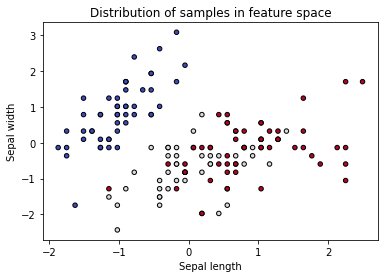

In [ ]:
# nos quedamos con las primeras dos columnas del dataset
only_two_features = dataset['X'][:,0:2]

# los graficamos
X0, X1 = only_two_features[:, 0], only_two_features[:, 1]
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.title('Distribution of samples in feature space')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Vemos que la clase 0 es linealmente separable respecto a las clases 1 y 2, pero que estas dos no pueden diferenciarse tan fácilmente.

Chequeemos qué ocurre si aplicamos una SVM linear sobre estos datos. En lugar de usar LinearSVC como veníamos usando hasta ahora, vamos a usar SVC de Sklearn, pasándole ```kernel='linear'```. Esto equivale a pedirle a la SVM que no utilice ningún kernel, si no que trabaje como el modelo original.

In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

xx, yy = make_meshgrid(X0, X1)

OVR Linear SVM
-----------------------
svm with C=0.001 --> Acc=0.7333+-0.0816
svm with C=0.01 --> Acc=0.7600+-0.0573
svm with C=0.1 --> Acc=0.7867+-0.0957
svm with C=1 --> Acc=0.7867+-0.0748
svm with C=10 --> Acc=0.7933+-0.0742
svm with C=100 --> Acc=0.7867+-0.0748
svm with C=1000 --> Acc=0.7933+-0.0742
-----------------------
Best C: 10
Average accuracy: 0.7933+-0.0742
-----------------------


Text(0.5, 1.0, 'OVR Linear SVM')

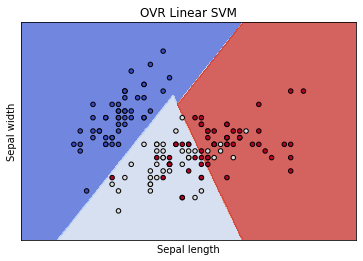

In [ ]:
from sklearn.svm import SVC

# le ponemos un nombre largo
long_name = 'OVR Linear SVM'

# valores de C que vamos a probar
C_values = [-3, -2, -1, 0, 1, 2, 3]

# arreglo para ir guardando los valores de accuracy
linear_svm_mean_accuracy = np.zeros(len(C_values))
linear_svm_std_accuracy = np.zeros(len(C_values))
linear_svm_models = []

# iteramos por cada valor de C
i = 0
print(long_name)
print('-----------------------')
for c_idx in C_values:
  # definimos el modelo
  model = SVC(C=10**c_idx, kernel='linear')
  linear_svm_models.append(model)
  # usamos cross validation para evaluar la performance en cada fold
  accuracy_per_fold = cross_val_score(model, 
                                      only_two_features, dataset['y'], 
                                      cv=dataset['cross-val-partition'], 
                                      scoring='accuracy')
  # tomamos los valores promedio de accuracy, y tmb el desvío
  linear_svm_mean_accuracy[i] = np.mean(accuracy_per_fold)
  linear_svm_std_accuracy[i] = np.std(accuracy_per_fold)
  # imprimimos
  print('{} with C={} --> Acc={:.4f}+-{:.4f}'.format(classifier, 10**c_idx, linear_svm_mean_accuracy[i], linear_svm_std_accuracy[i]))
  i=i+1

# identificamos el mejor valor de C a partir del accuracy más alto
C_idx = np.argmax(linear_svm_mean_accuracy)
# imprimimos los resultados por pantalla
print('-----------------------')
print('Best C: {}'.format(10**C_values[C_idx]))
print('Average accuracy: {:.4f}+-{:.4f}'.format(linear_svm_mean_accuracy[C_idx], linear_svm_std_accuracy[C_idx]))
print('-----------------------')

# la entrenamos sobre todos los datos
linear_svm_model = SVC(C=10**C_values[C_idx], kernel='linear')
linear_svm_model.fit(only_two_features, dataset['y'])

# graficamos los modelos sobre nuestros datos
fig, ax = plt.subplots()
plot_contours(ax, linear_svm_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(long_name)

Podemos ver que el modelo lineal hizo lo que pudo para las clases 1 y 2 (que en principio no parece estar nada mal).

Veamos qué ocurre ahora si aplicamos una SVM con un kernel RBF. Recuerden que acá tenemos un hiperparámetro extra: $\gamma$, que es el multiplicador de la función. Esto implica que la búsqueda que hacíamos antes del valor óptimo de $C$ tenemos que hacerla en conjunto con $\gamma$. Hagamos esa búsqueda así de paso vemos cómo graficar la evolución conjunta de dos hiperparámetros a la vez.

SVM with RBF kernel
-----------------------
Best C = 0.001
Best gamma = 0.125
Accuracy on validation set = 0.8000
-----------------------


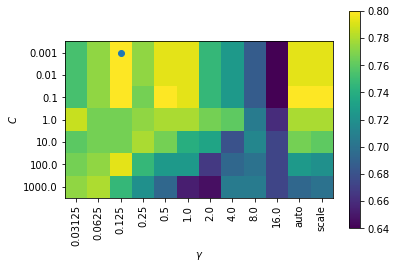

In [ ]:
from sklearn.svm import SVC

verbose = False

# elegimos el kernel
kernel = 'rbf'

# inicializamos la lista de valores de C
C_values = [-3, -2, -1, 0, 1, 2, 3]
# creamos una lista de valores de gamma para la RBF (incluyendo 'auto' y 'scale')
gamma_values = list(2.0**np.arange(-5, 5)) + ['auto', 'scale']

# inicializamos una matriz en la que iremos guardando los valores de accuracy promedio
kernel_classifier_mean_accuracy = np.zeros((len(C_values), len(gamma_values)))

# iteramos por cada valor de C y cada valor de gamma
print('SVM with RBF kernel')
current_accuracy = -1.0
best_model = None
for c_i in range(len(C_values)):
  for gamma_i in range(len(gamma_values)):
    # definimos el modelo
    model = SVC(C=10**C_values[c_i], kernel=kernel, gamma=gamma_values[gamma_i])
    # usamos cross validation para evaluar la performance en cada fold
    accuracy_per_fold = cross_val_score(model, 
                                        only_two_features, dataset['y'], 
                                        cv=dataset['cross-val-partition'], 
                                        scoring='accuracy')
    if np.mean(accuracy_per_fold) > current_accuracy:
      best_model = model
      current_accuracy = np.mean(accuracy_per_fold)
    # tomamos los valores promedio de accuracy
    kernel_classifier_mean_accuracy[c_i, gamma_i] = np.mean(accuracy_per_fold)
    # imprimimos (si queremos)
    if verbose:
      print('Kernel SVM with C={} gamma={} --> Acc={:.4f}'.format(10**C_values[c_i], gamma_values[c_i], kernel_classifier_mean_accuracy[c_i, gamma_i]))

# buscamos el elemento con mejor accuracy
indices = np.unravel_index(np.argmax(kernel_classifier_mean_accuracy), kernel_classifier_mean_accuracy.shape)
print('-----------------------')
print('Best C = {}'.format(10.0**C_values[indices[0]]))
print('Best gamma = {}'.format(gamma_values[indices[1]]))
print('Accuracy on validation set = {:.4f}'.format(kernel_classifier_mean_accuracy[indices[0], indices[1]]))
print('-----------------------')

# imprimimos la matriz de calidades como una imagen
fig, ax = plt.subplots()
pos = ax.imshow(kernel_classifier_mean_accuracy)
ax.set_xticks(np.arange(0,len(gamma_values)))
ax.set_xticklabels(np.asarray(gamma_values,dtype=str), rotation=90)

ax.set_yticks(np.arange(0,len(C_values)))
ax.set_yticklabels(10.0**np.array(C_values))
ax.scatter(indices[1], indices[0])
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$C$')
fig.colorbar(pos, ax=ax)
plt.show()


Una estrategia para poder ver la evolución de ambas variables a la vez es utilizar un heatmap. En este tipo de gráficos mostramos un mapa de calor donde las zonas frías corresponden a valores bajos de performance, y las calientes a valores altos. También agregamos un punto en el lugar donde tenemos la mejor combinación de parámetros.

Ahora que conocemos esa configuración óptima, entrenemos el modelo sobre todos los datos y veamos qué obtenemos.

Text(0.5, 1.0, 'OVR Linear SVM')

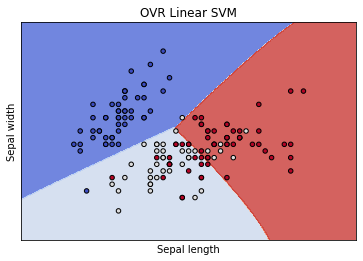

In [ ]:
# la entrenamos sobre todos los datos
rbf_svm_model = SVC(C=10**C_values[indices[0]], kernel='rbf', gamma=gamma_values[indices[1]])
rbf_svm_model.fit(only_two_features, dataset['y'])

# graficamos los modelos sobre nuestros datos
fig, ax = plt.subplots()
plot_contours(ax, rbf_svm_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(long_name)

En este caso se ve con claridad que el algoritmo no mejora significativamente al intentar buscar un borde no-lineal. Esto puede ocurrir muchas veces! Es importante que lo tengan en cuenta siempre, ya que muchas librerías incluyen el RBF por defecto como kernel para la SVM, y puede que terminen usando un modelo subóptimo. Siempre hay que probar todo: lineal y no-lineal, y quedarse con el mejor.

Con esto terminamos la unidad 4!